# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [3]:
Mode5 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode5/Mode5.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode5.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
GLOBAL_SAVE_CALIBRATE = true;

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [19]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-11-07 20:19:53] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[2024-11-07 20:19:58] Info: Done With Floquet Sweep
[2024-11-07 20:19:58] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0003603158191560377	 0.00895417250937016	 2.0067056283278726
Stark shift res: [0.0003603158191560377, 55.653293958300814]


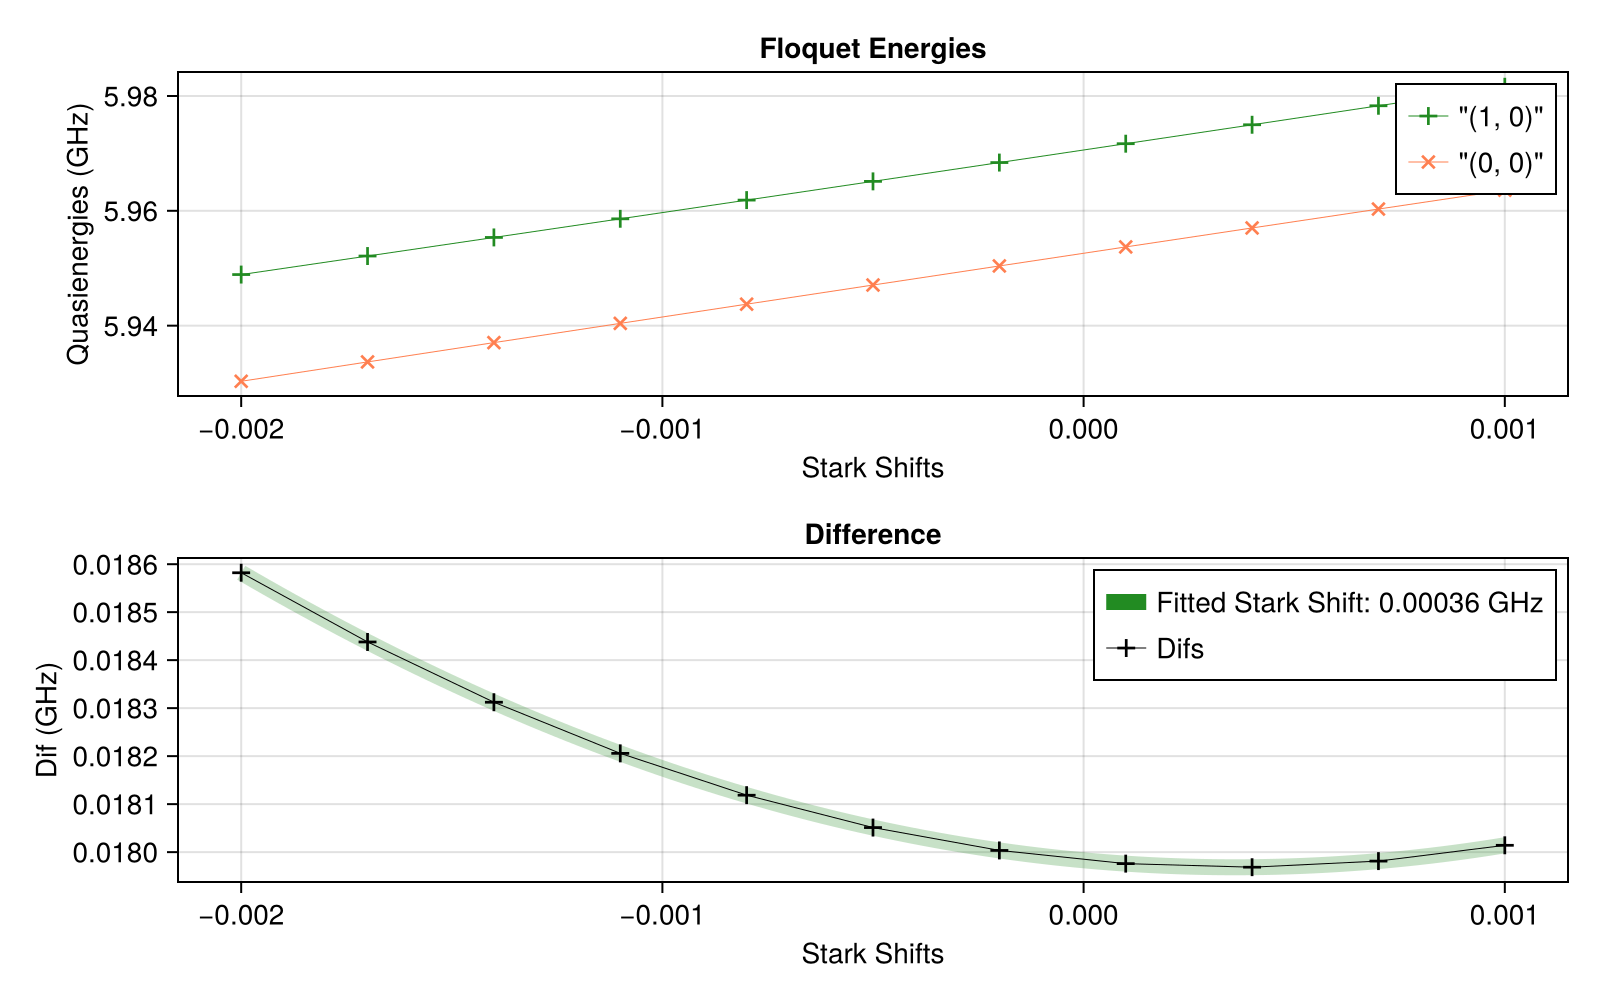

In [20]:
ge_ε = 0.00538
drive_op = Mode5.n̂ₜ
state1 = (0,0)
state2 = (1,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode5, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $|1,0\rangle+|0,1\rangle \to |0,0\rangle+|1,1\rangle$

In [21]:

ψ1 = Mode5.dressed_states[(1,0)]+Mode5.dressed_states[(0,1)]
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode5.dressed_states[(0,0)]+Mode5.dressed_states[(1,1)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d_e0 = Mode5.dressed_energies[(1,0)]-Mode5.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode5.dressed_energies[(1,1)]-Mode5.dressed_energies[(0,1)]+ge_stark_shift

freq_d = (freq_d_e0+freq_d_g1)/2

check_op = proj_dict[(0,0)]+proj_dict[(1,1)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

#qubit_ε = qubit_ε

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_half = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-07 20:19:58] Info: On Level 1
[2024-11-07 20:19:58] Info: On Step 1: t = 90.0
[2024-11-07 20:19:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:19:59] Info: Time Evolution Complete
[2024-11-07 20:19:59] Info: Done with Level_1_step_1
[2024-11-07 20:19:59] Info: Accurace: 0.9969897785490957
[2024-11-07 20:19:59] Info: ------------------------------------------------------------------------------
[2024-11-07 20:19:59] Info: On Step 2: t = 92.5
[2024-11-07 20:19:59] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:20:01] Info: Time Evolution Complete
[2024-11-07 20:20:02] Info: Done with Level_1_step_2
[2024-11-07 20:20:02] Info: Accurace: 0.9994363743219781
[2024-11-07 20:20:02] Info: ------------------------------------------------------------------------------
[2024-11-07 20:20:02] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.9995
  "freq_d"        => 4.60385

In [22]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ge_1/2"] = deepcopy(qubit_ge_half)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.9995
  "freq_d"        => 4.60385

In [23]:
ψ = Mode5.dressed_states[(1,0)]+Mode5.dressed_states[(0,1)]
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_half_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ge_1/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:20:56.559
It is being saved at: Data/
[2024-11-07 20:20:56] Info: Running operator q_ge_1/2
[2024-11-07 20:20:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-07 20:21:00] Info: Time Evolution Complete
[2024-11-07 20:21:00] Info: Saving Steps
[2024-11-07 20:21:01] Info: Done with Step_1
[2024-11-07 20:21:01] Info: Done With Running Sequence
[2024-11-07 20:21:01] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [24]:
EVs = SC.Utils.Get_EVs(q_ge_half_res["states"], proj_dict);

[2024-11-07 20:21:01] Info: Making Plot


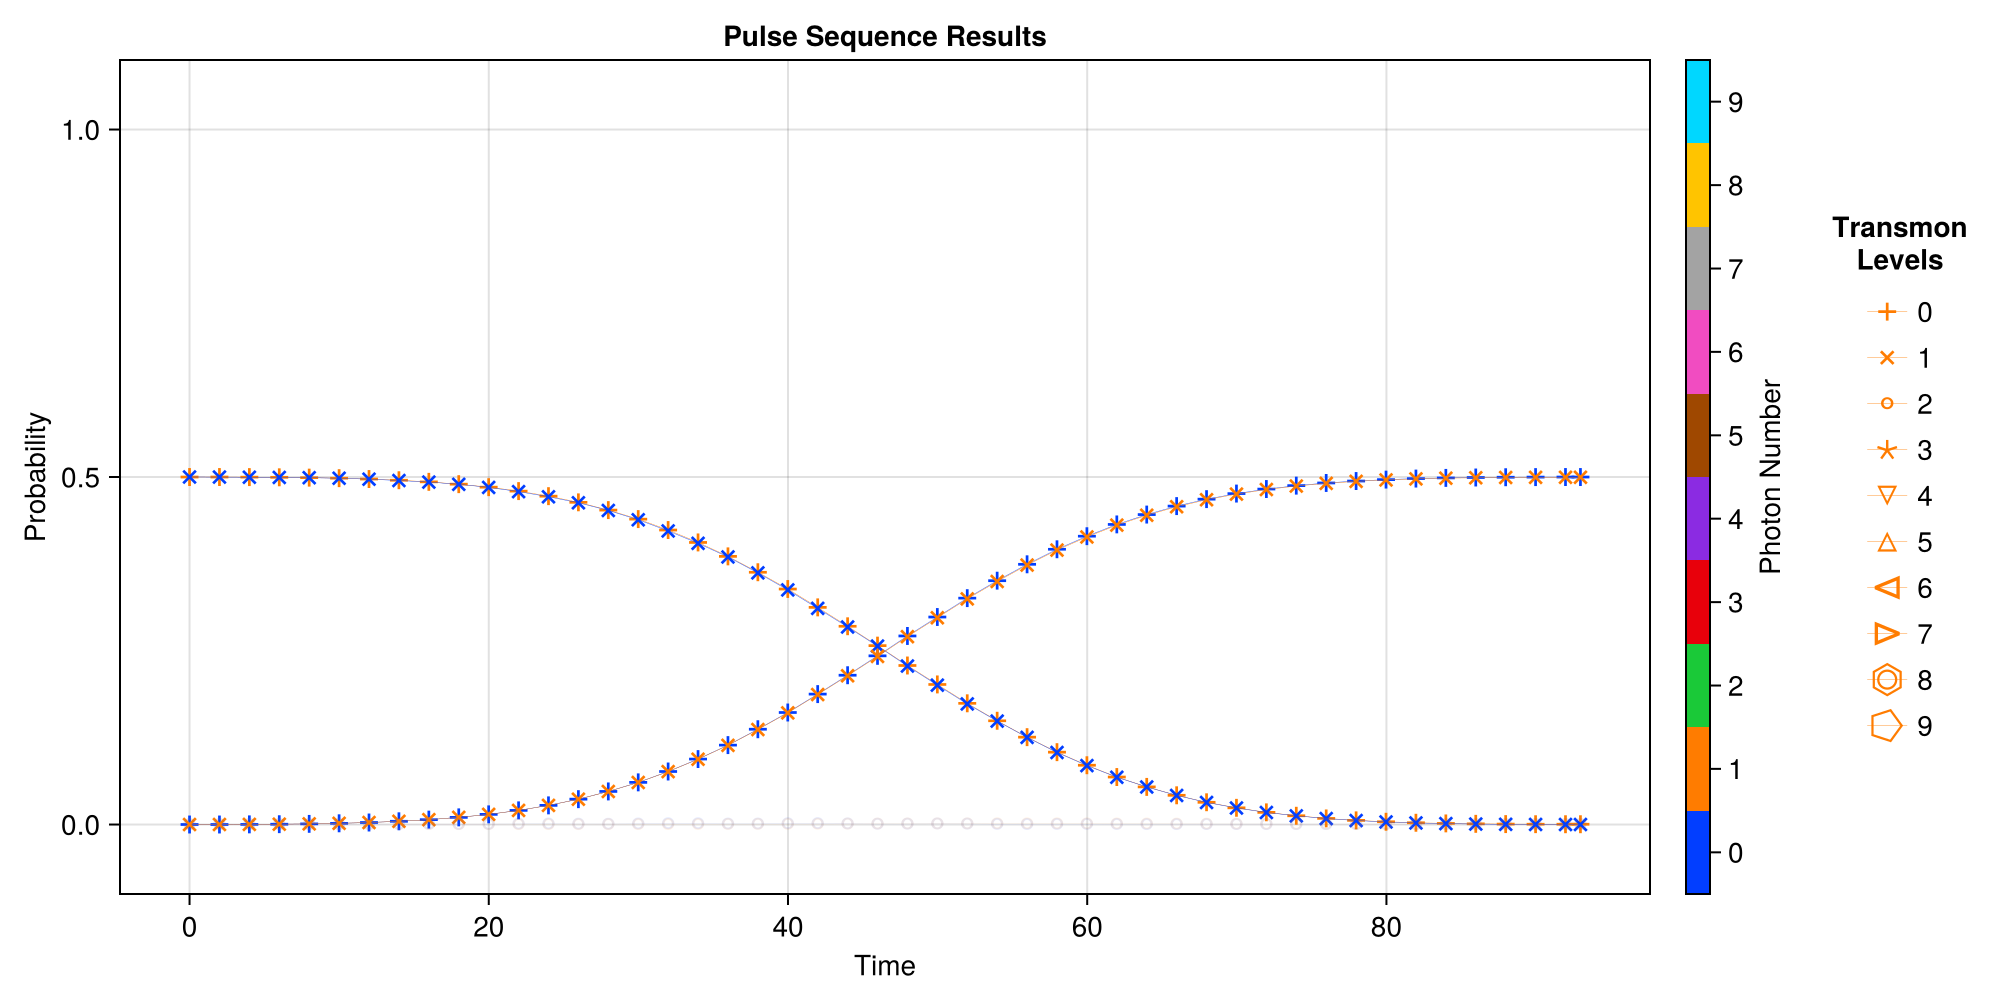

CairoMakie.Screen{IMAGE}


In [25]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ge_half_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1)])

In [26]:
println(EVs[(0,0)][end])
println(EVs[(1,1)][end])

0.4999646185432925 - 5.404624213983653e-17im
0.4995987464484623 - 3.647680165038425e-18im


In [27]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997339249911 - 5.76281294966568e-17im

#### $|0,0\rangle \to |1,0\rangle$

In [28]:
state1 = (0,0)
state2 = (1,0)
ψ1 = Mode5.dressed_states[state1]
ψ2 = Mode5.dressed_states[state2]

freq_d = Mode5.dressed_energies[state2]-Mode5.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge0_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-07 20:21:02] Info: On Level 1
[2024-11-07 20:21:02] Info: On Step 1: t = 90.0
[2024-11-07 20:21:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:21:03] Info: Time Evolution Complete
[2024-11-07 20:21:03] Info: Done with Level_1_step_1
[2024-11-07 20:21:03] Info: Accurace: 0.9969122871673516
[2024-11-07 20:21:03] Info: ------------------------------------------------------------------------------
[2024-11-07 20:21:03] Info: On Step 2: t = 92.5
[2024-11-07 20:21:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:21:06] Info: Time Evolution Complete
[2024-11-07 20:21:06] Info: Done with Level_1_step_2
[2024-11-07 20:21:06] Info: Accurace: 0.9993594557886801
[2024-11-07 20:21:06] Info: ------------------------------------------------------------------------------
[2024-11-07 20:21:06] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999424
  "freq_d"        => 4.60394

In [29]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge0_opt_res)
end


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999424
  "freq_d"        => 4.60394

In [30]:
ψ = Mode5.dressed_states[(0,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge0_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ge_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:21:54.193
It is being saved at: Data/
[2024-11-07 20:21:54] Info: Running operator q_ge_0
[2024-11-07 20:21:54] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-07 20:21:57] Info: Time Evolution Complete
[2024-11-07 20:21:57] Info: Saving Steps
[2024-11-07 20:21:58] Info: Done with Step_1
[2024-11-07 20:21:58] Info: Done With Running Sequence
[2024-11-07 20:21:58] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [31]:
EVs_ge0 = SC.Utils.Get_EVs(q_ge0_res["states"], proj_dict);

[2024-11-07 20:21:58] Info: Making Plot


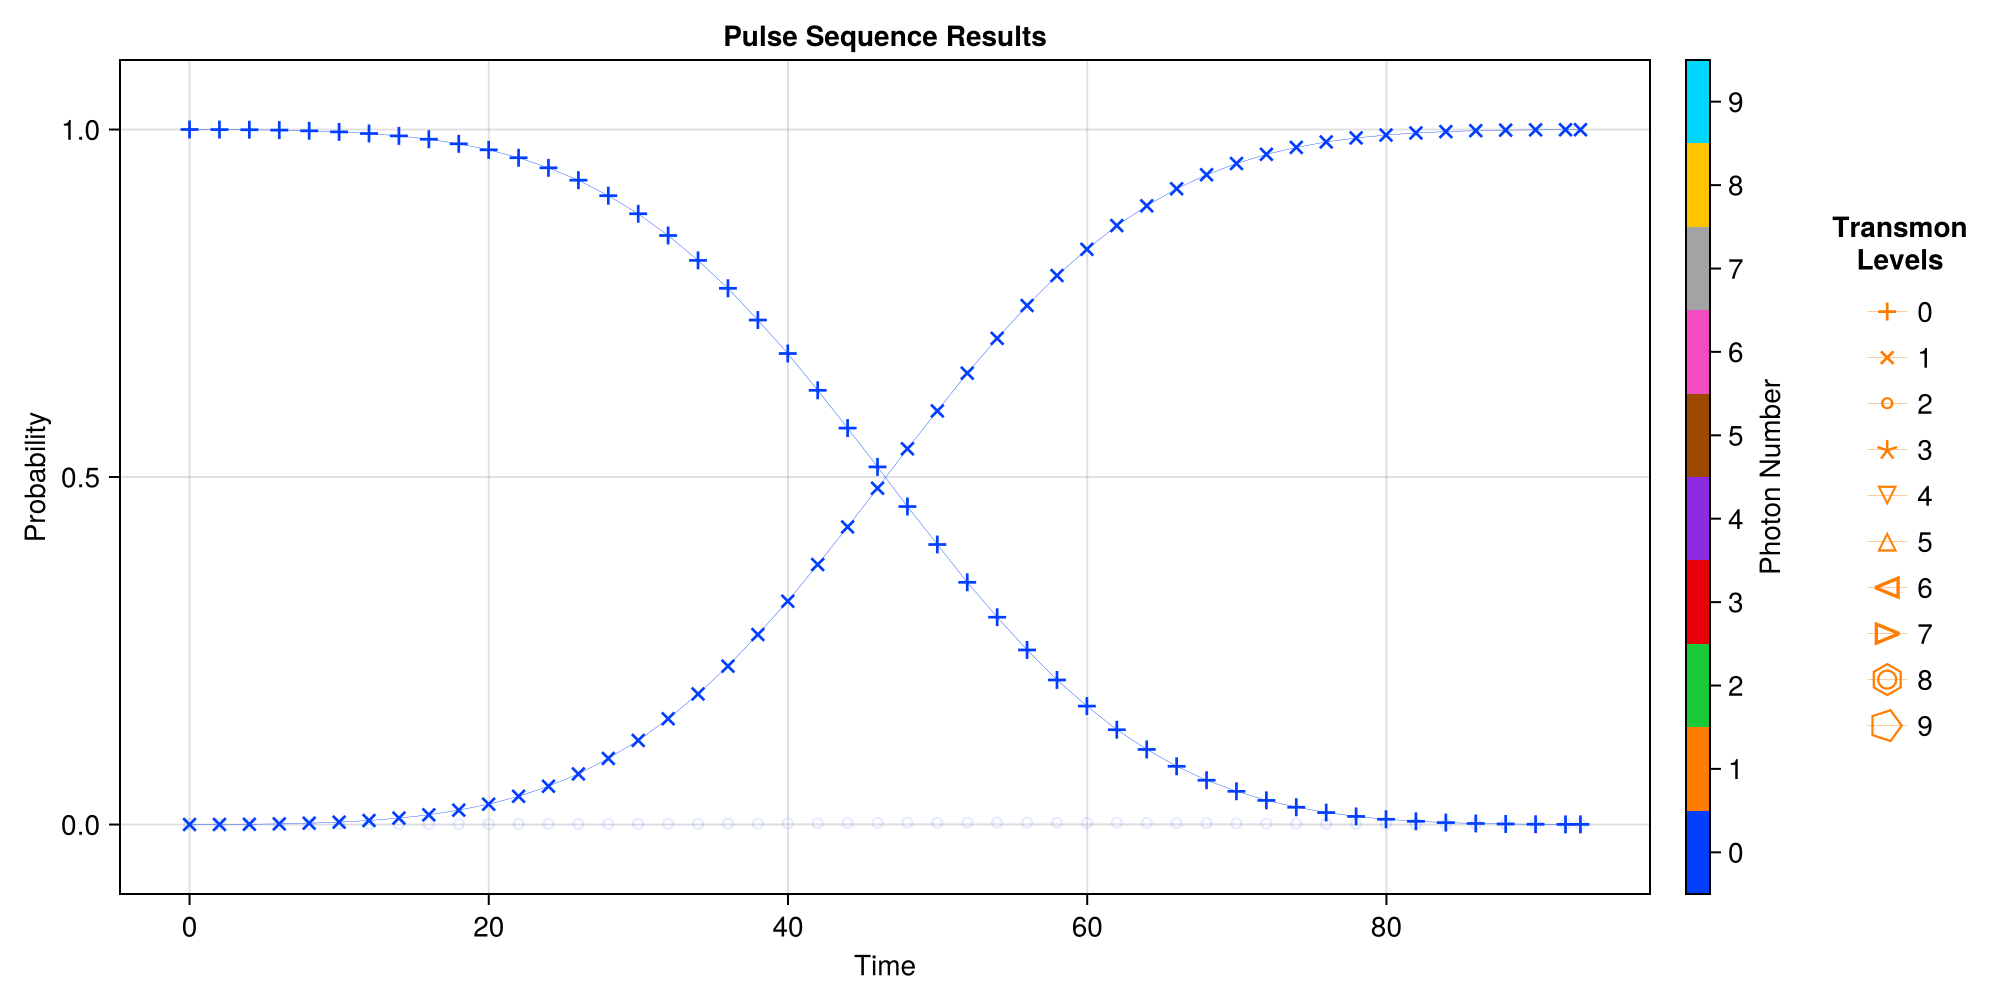

CairoMakie.Screen{IMAGE}


In [32]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ge0_res["times"], EVs_ge0, plot_every = 10, emph_states = [(0,0),(1,0)])

In [33]:
println(EVs_ge0[(0,0)][end])
println(EVs_ge0[(1,0)][end])
println(EVs_ge0[(2,0)][end])

0.00022520352515667037 + 1.9326971541870936e-21im
0.9997122857575792 - 1.3079647124558306e-17im
6.210681421349332e-5 + 5.192071334106209e-21im


In [34]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997339249911 - 5.76281294966568e-17im

#### $|0,1\rangle \to |1,1\rangle$

In [35]:
state1 = (0,1)
state2 = (1,1)
ψ1 = Mode5.dressed_states[state1]
ψ2 = Mode5.dressed_states[state2]

freq_d = Mode5.dressed_energies[state2]-Mode5.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge1_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-07 20:21:58] Info: On Level 1
[2024-11-07 20:21:58] Info: On Step 1: t = 90.0
[2024-11-07 20:21:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:22:00] Info: Time Evolution Complete
[2024-11-07 20:22:00] Info: Done with Level_1_step_1
[2024-11-07 20:22:00] Info: Accurace: 0.9971804531937684
[2024-11-07 20:22:00] Info: ------------------------------------------------------------------------------
[2024-11-07 20:22:00] Info: On Step 2: t = 92.5
[2024-11-07 20:22:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:22:02] Info: Time Evolution Complete
[2024-11-07 20:22:02] Info: Done with Level_1_step_2
[2024-11-07 20:22:02] Info: Accurace: 0.9996400334727322
[2024-11-07 20:22:02] Info: ------------------------------------------------------------------------------
[2024-11-07 20:22:02] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999705
  "freq_d"        => 4.60376

In [36]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ge_1"] = deepcopy(qubit_ge1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999705
  "freq_d"        => 4.60376

In [37]:
ψ = Mode5.dressed_states[(0,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge1_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ge_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:22:52.765
It is being saved at: Data/
[2024-11-07 20:22:52] Info: Running operator q_ge_1
[2024-11-07 20:22:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:22:55] Info: Time Evolution Complete
[2024-11-07 20:22:55] Info: Saving Steps
[2024-11-07 20:22:55] Info: Done with Step_1
[2024-11-07 20:22:55] Info: Done With Running Sequence
[2024-11-07 20:22:55] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [38]:
EVs = SC.Utils.Get_EVs(q_ge1_res["states"], proj_dict);

[2024-11-07 20:22:56] Info: Making Plot


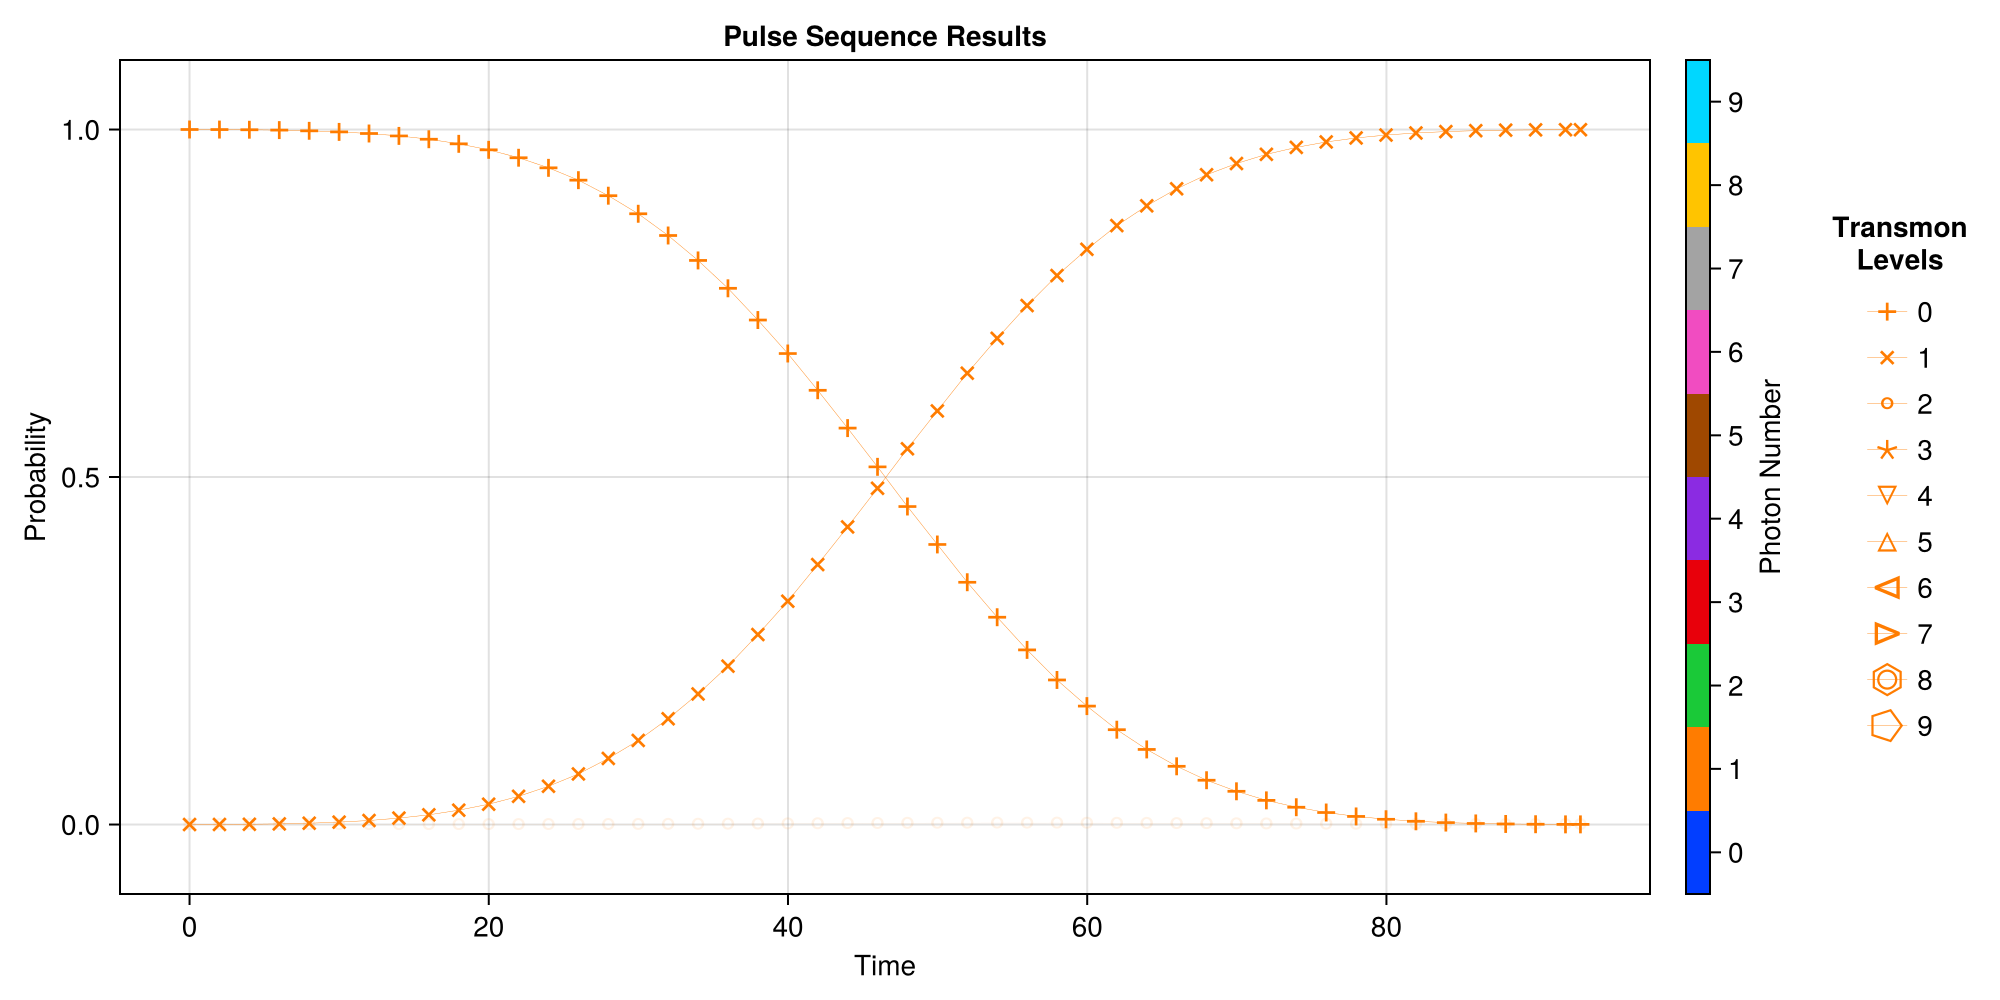

CairoMakie.Screen{IMAGE}


In [39]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ge1_res["times"], EVs, plot_every = 10, emph_states = [(0,1),(1,1)])

In [40]:
EVs[(1,1)][end]

0.9997104539304232 - 1.0870893078769459e-16im

In [41]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.999997649904401 - 1.086305965398501e-16im

#### $|0,0\rangle+(|1,1\rangle+|0,3\rangle)/\sqrt{2} \to |1,0\rangle+(|0,1\rangle+|1,3\rangle)/\sqrt{2}$

In [42]:

ψ1 = Mode5.dressed_states[(0,0)]+(Mode5.dressed_states[(1,1)]+Mode5.dressed_states[(0,3)])/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode5.dressed_states[(1,0)]+(Mode5.dressed_states[(0,1)]+Mode5.dressed_states[(1,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_g0 = Mode5.dressed_energies[(1,0)]-Mode5.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode5.dressed_energies[(1,1)]-Mode5.dressed_energies[(0,1)]+ge_stark_shift
freq_d_g3 = Mode5.dressed_energies[(1,3)]-Mode5.dressed_energies[(0,3)]+ge_stark_shift

χ = freq_d_g1-freq_d_g0

freq_d = freq_d_g0+4*χ/3

check_op = proj_dict[(1,0)]+proj_dict[(0,1)]+proj_dict[(1,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_four_thirds_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-07 20:22:56] Info: On Level 1
[2024-11-07 20:22:56] Info: On Step 1: t = 90.0
[2024-11-07 20:22:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:22:58] Info: Time Evolution Complete
[2024-11-07 20:22:58] Info: Done with Level_1_step_1
[2024-11-07 20:22:58] Info: Accurace: 0.9963701368612436
[2024-11-07 20:22:58] Info: ------------------------------------------------------------------------------
[2024-11-07 20:22:58] Info: On Step 2: t = 92.5
[2024-11-07 20:22:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:23:00] Info: Time Evolution Complete
[2024-11-07 20:23:00] Info: Done with Level_1_step_2
[2024-11-07 20:23:00] Info: Accurace: 0.99877842787155
[2024-11-07 20:23:00] Info: ------------------------------------------------------------------------------
[2024-11-07 20:23:00] Info: On St

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998834
  "freq_d"        => 4.6037

In [43]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ge_4/3"] = deepcopy(qubit_ge_four_thirds_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998834
  "freq_d"        => 4.6037

In [44]:
ψ = Mode5.dressed_states[(1,1)]+(Mode5.dressed_states[(0,0)]+Mode5.dressed_states[(0,3)])/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_four_thirds_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ge_4/3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:23:48.691
It is being saved at: Data/
[2024-11-07 20:23:48] Info: Running operator q_ge_4/3
[2024-11-07 20:23:48] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-07 20:23:52] Info: Time Evolution Complete
[2024-11-07 20:23:52] Info: Saving Steps
[2024-11-07 20:23:53] Info: Done with Step_1
[2024-11-07 20:23:53] Info: Done With Running Sequence
[2024-11-07 20:23:53] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [45]:
EVs = SC.Utils.Get_EVs(q_ge_four_thirds_res["states"], proj_dict);

[2024-11-07 20:23:53] Info: Making Plot


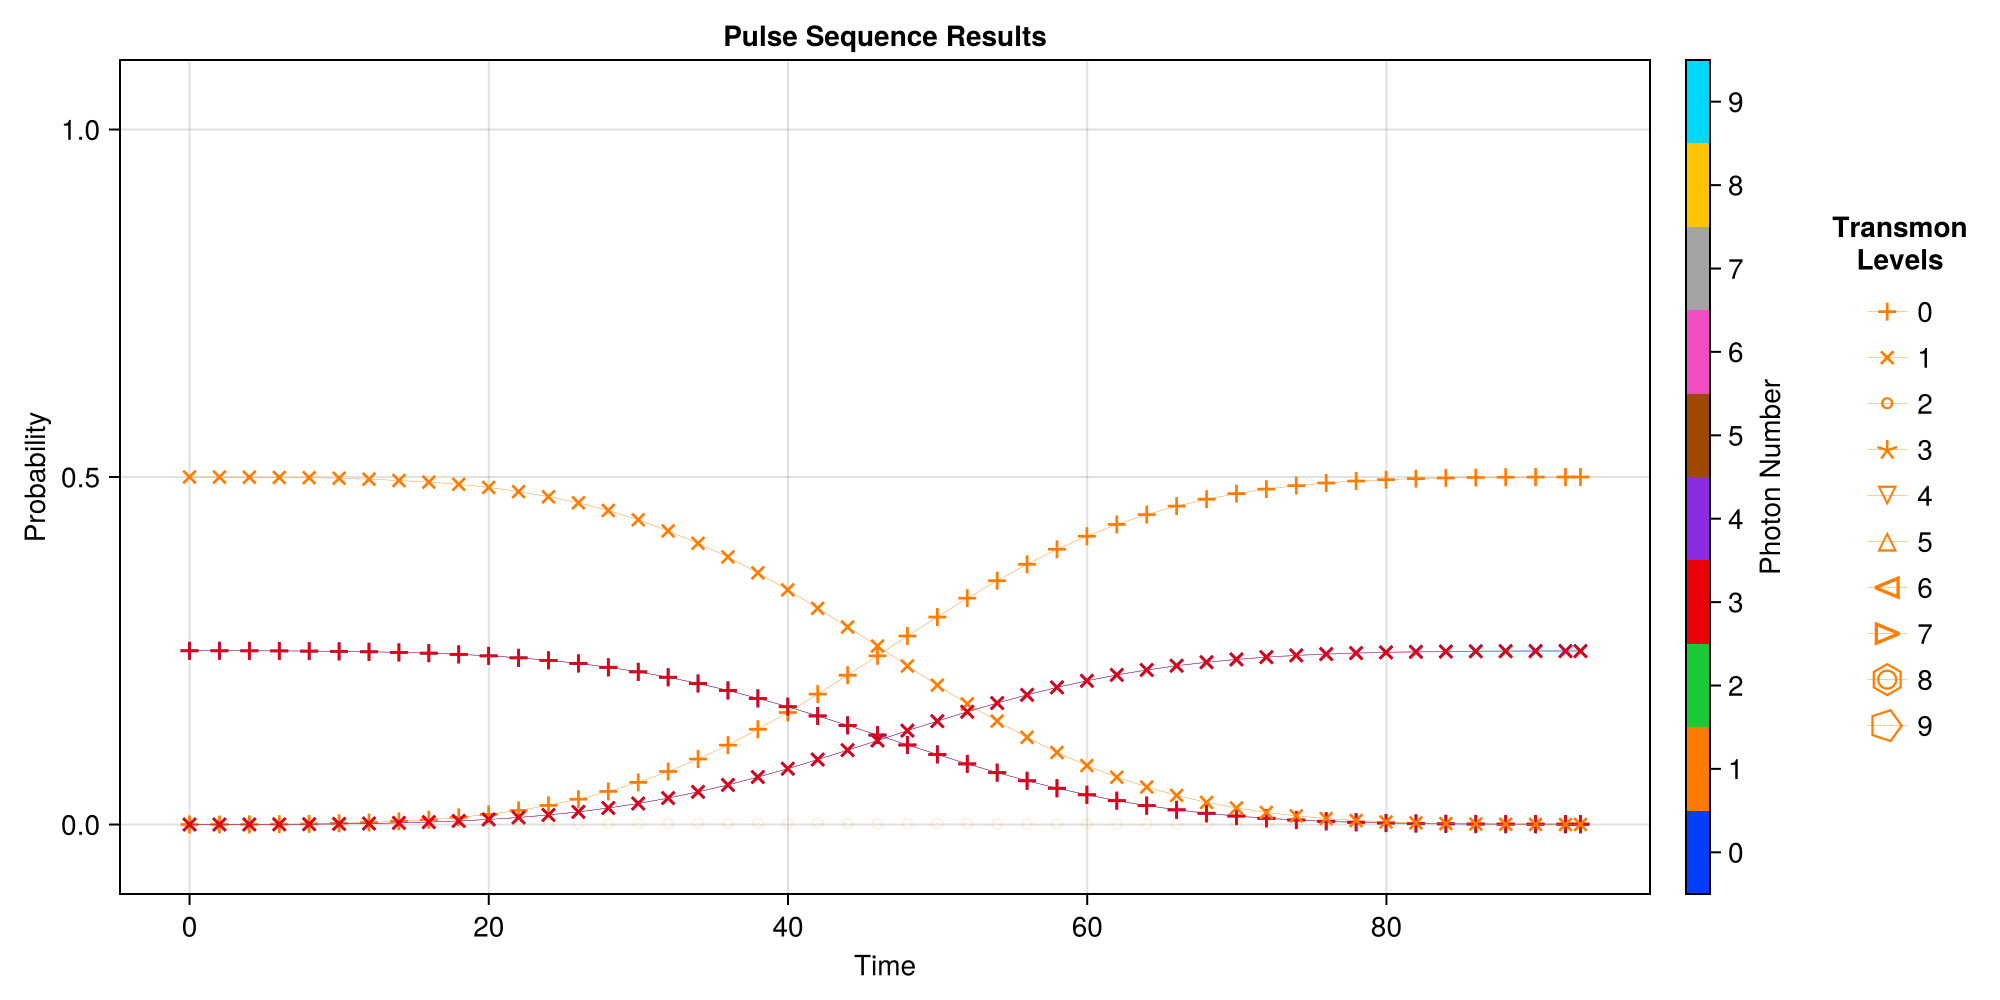

CairoMakie.Screen{IMAGE}


In [46]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ge_four_thirds_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1),(0,3),(1,3)])

In [47]:
println(EVs[(0,1)][end])
println(EVs[(1,0)][end])
println(EVs[(1,3)][end])

0.49994525679697255 + 6.248422546203592e-17im
0.2499069724048202 + 4.247161204809976e-17im
0.2492097724164928 + 1.9459729603677463e-17im


In [48]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998207449221 + 1.2449223145905193e-16im

#### $|0,2\rangle \to |1,2\rangle$

In [49]:
state1 = (0,2)
state2 = (1,2)
ψ1 = Mode5.dressed_states[state1]
ψ2 = Mode5.dressed_states[state2]

freq_d = Mode5.dressed_energies[state2]-Mode5.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge2_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-07 20:23:53] Info: On Level 1
[2024-11-07 20:23:53] Info: On Step 1: t = 90.0
[2024-11-07 20:23:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:23:55] Info: Time Evolution Complete
[2024-11-07 20:23:55] Info: Done with Level_1_step_1
[2024-11-07 20:23:55] Info: Accurace: 0.9971837655648621
[2024-11-07 20:23:55] Info: ------------------------------------------------------------------------------
[2024-11-07 20:23:55] Info: On Step 2: t = 92.5
[2024-11-07 20:23:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:23:57] Info: Time Evolution Complete
[2024-11-07 20:23:57] Info: Done with Level_1_step_2
[2024-11-07 20:23:57] Info: Accurace: 0.9996467714777212
[2024-11-07 20:23:57] Info: ------------------------------------------------------------------------------
[2024-11-07 20:23:57] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60359

In [50]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ge_2"] = deepcopy(qubit_ge2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60359

In [51]:
ψ = Mode5.dressed_states[(0, 2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge2_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ge_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:24:44.452
It is being saved at: Data/
[2024-11-07 20:24:44] Info: Running operator q_ge_2
[2024-11-07 20:24:44] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:24:46] Info: Time Evolution Complete
[2024-11-07 20:24:46] Info: Saving Steps
[2024-11-07 20:24:46] Info: Done with Step_1
[2024-11-07 20:24:46] Info: Done With Running Sequence
[2024-11-07 20:24:46] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [52]:
EVs = SC.Utils.Get_EVs(q_ge2_res["states"], proj_dict);

[2024-11-07 20:24:47] Info: Making Plot


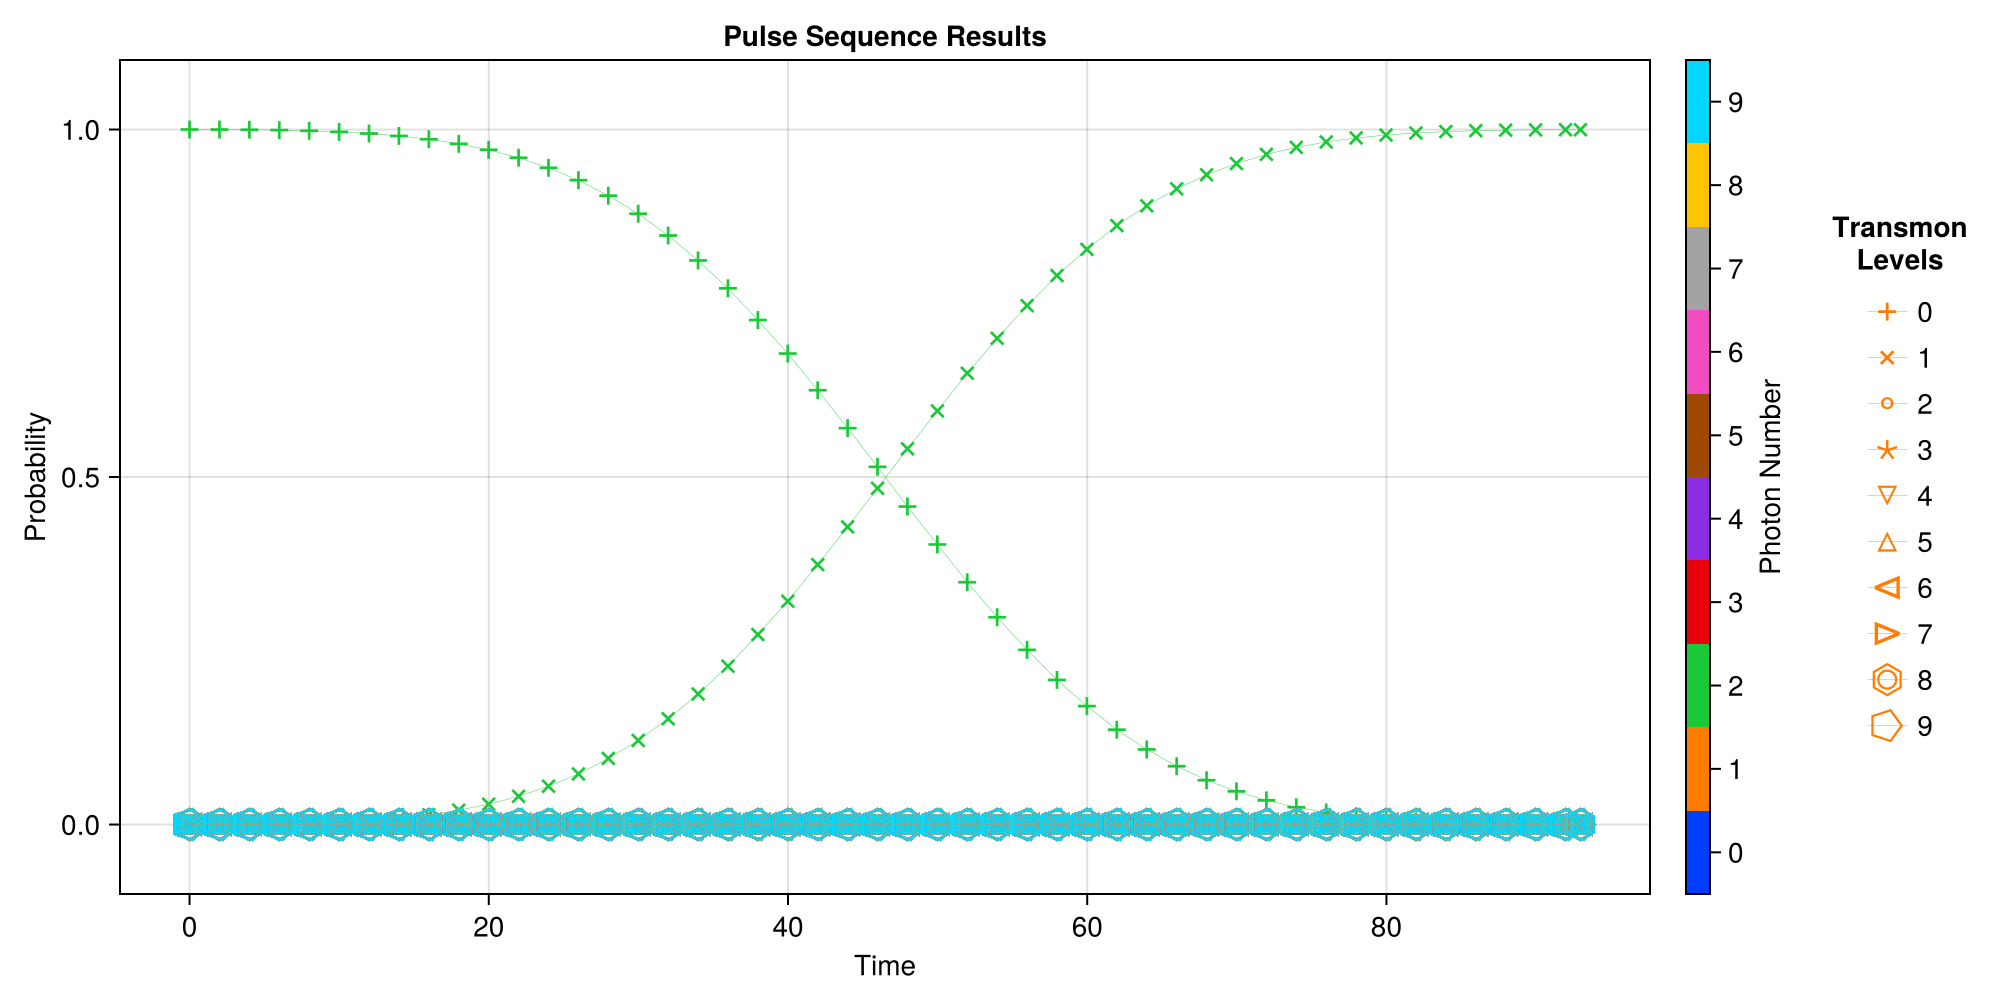

CairoMakie.Screen{IMAGE}


In [53]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ge2_res["times"], EVs, plot_every = 10)

In [54]:
EVs[(1,2)][end]

0.9997128534261729 - 2.197656537579871e-17im

In [55]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999586378631 - 2.216186997571292e-17im

#### $|0,3\rangle \to |1,3\rangle$

In [56]:
state1 = (0,3)
state2 = (1,3)
ψ1 = Mode5.dressed_states[state1]
ψ2 = Mode5.dressed_states[state2]

freq_d = Mode5.dressed_energies[state2]-Mode5.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge3_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-07 20:24:47] Info: On Level 1
[2024-11-07 20:24:47] Info: On Step 1: t = 90.0
[2024-11-07 20:24:47] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:24:50] Info: Time Evolution Complete
[2024-11-07 20:24:50] Info: Done with Level_1_step_1
[2024-11-07 20:24:50] Info: Accurace: 0.9971796781869889
[2024-11-07 20:24:50] Info: ------------------------------------------------------------------------------
[2024-11-07 20:24:50] Info: On Step 2: t = 92.5
[2024-11-07 20:24:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:24:52] Info: Time Evolution Complete
[2024-11-07 20:24:52] Info: Done with Level_1_step_2
[2024-11-07 20:24:52] Info: Accurace: 0.999646189871772
[2024-11-07 20:24:52] Info: ------------------------------------------------------------------------------
[2024-11-07 20:24:52] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60341

In [57]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ge_3"] = deepcopy(qubit_ge3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60341

In [58]:
ψ = Mode5.dressed_states[(0, 3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge3_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ge_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:25:44.199
It is being saved at: Data/
[2024-11-07 20:25:44] Info: Running operator q_ge_3
[2024-11-07 20:25:44] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:25:46] Info: Time Evolution Complete
[2024-11-07 20:25:46] Info: Saving Steps
[2024-11-07 20:25:47] Info: Done with Step_1
[2024-11-07 20:25:47] Info: Done With Running Sequence
[2024-11-07 20:25:47] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [59]:
EVs = SC.Utils.Get_EVs(q_ge3_res["states"], proj_dict);

[2024-11-07 20:25:47] Info: Making Plot


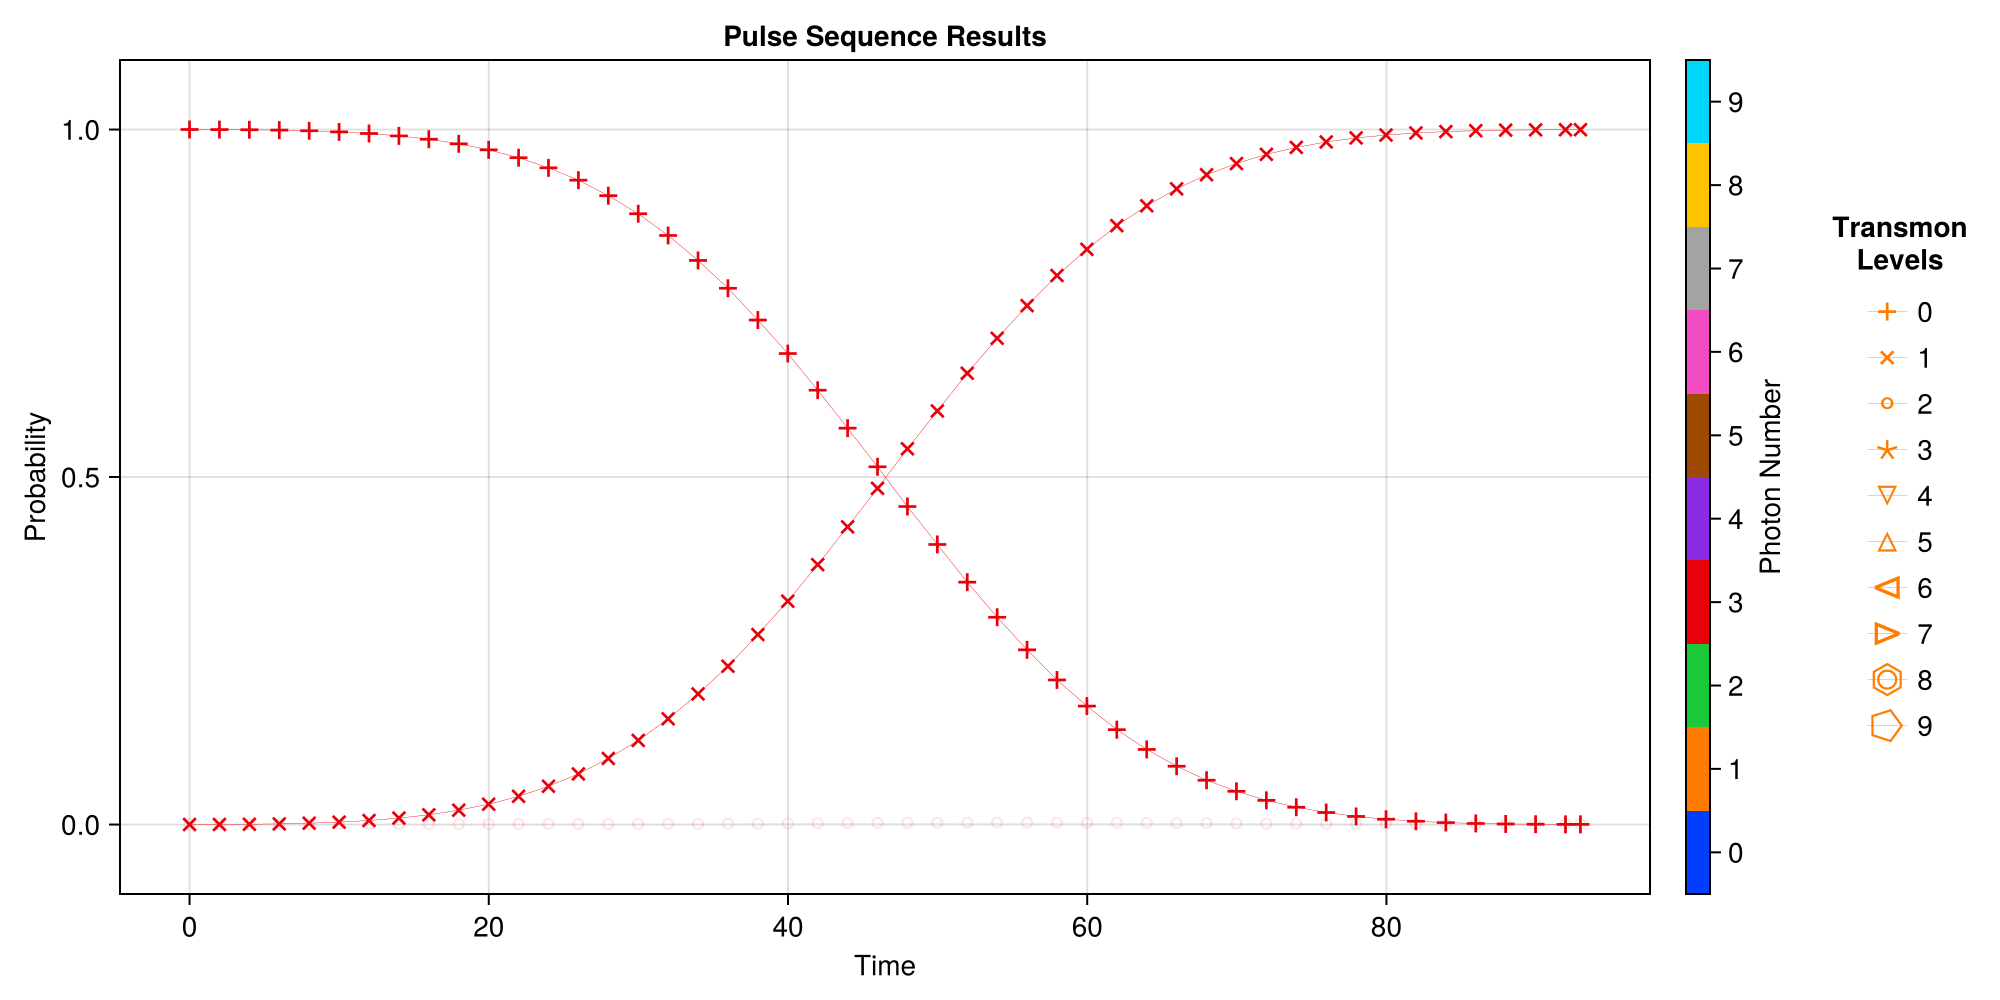

CairoMakie.Screen{IMAGE}


In [60]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ge3_res["times"], EVs, plot_every = 10, emph_states = [(0,3),(1,3)])

In [61]:
EVs[(1,3)][end]

0.9997129582599749 + 4.2539036013373614e-17im

In [62]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999964246223 + 4.373680634477863e-17im

### Guassian e -> f

In [63]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


##### Getting Stark Shift

[2024-11-07 20:25:47] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[2024-11-07 20:25:52] Info: Done With Floquet Sweep
[2024-11-07 20:25:52] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00016525387078676946	 0.008956830883096439	 2.006284182479506
Stark shift res: [0.00016525387078676946, 55.64846336749778]


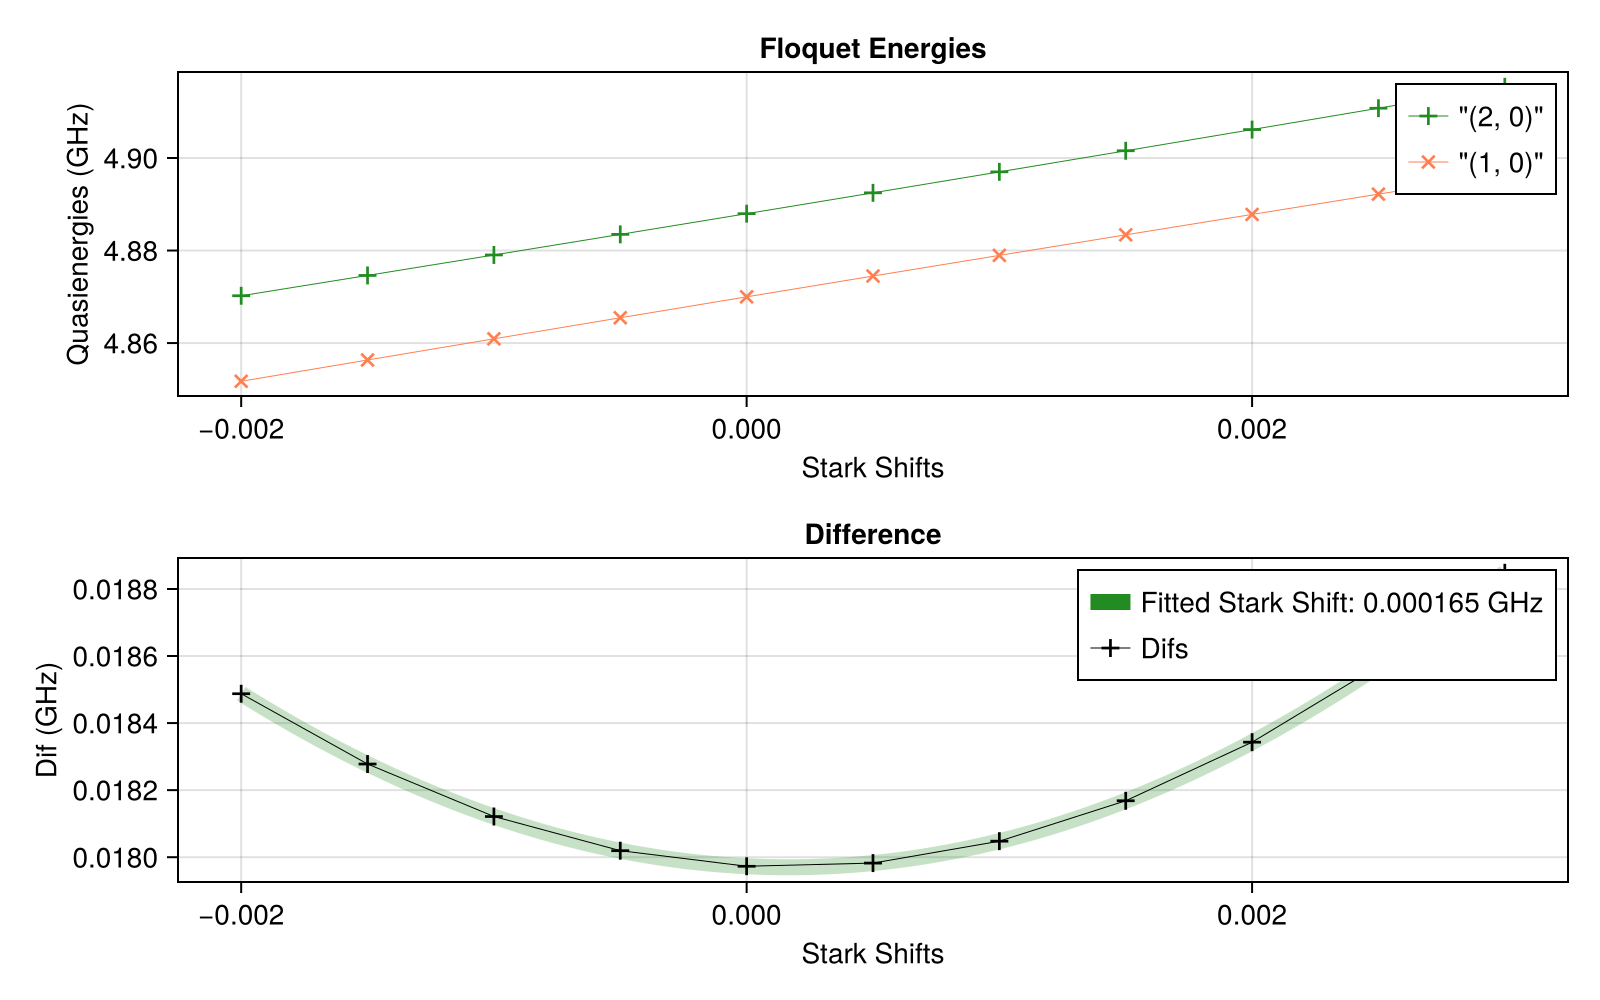

In [64]:
ef_ε = 0.00385
drive_op = Mode5.n̂ₜ
state1 = (1,0)
state2 = (2,0)

stark_shift_list = collect(LinRange(-0.002, 0.003, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode5, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))

ef_stark_shift = stark_shift_res[1];

##### $|1,0\rangle \to |2,0\rangle$

In [65]:
state1 = (1,0)
state2 = (2,0)
ψ1 = Mode5.dressed_states[state1]
ψ2 = Mode5.dressed_states[state2]

freq_d = Mode5.dressed_energies[state2]-Mode5.dressed_energies[state1] + ef_stark_shift


envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef0_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-07 20:25:53] Info: On Level 1
[2024-11-07 20:25:53] Info: On Step 1: t = 90.0
[2024-11-07 20:25:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:25:54] Info: Time Evolution Complete
[2024-11-07 20:25:54] Info: Done with Level_1_step_1
[2024-11-07 20:25:54] Info: Accurace: 0.9973354518529901
[2024-11-07 20:25:54] Info: ------------------------------------------------------------------------------
[2024-11-07 20:25:54] Info: On Step 2: t = 92.5
[2024-11-07 20:25:54] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:25:56] Info: Time Evolution Complete
[2024-11-07 20:25:56] Info: Done with Level_1_step_2
[2024-11-07 20:25:56] Info: Accurace: 0.9998027721265503
[2024-11-07 20:25:56] Info: ------------------------------------------------------------------------------
[2024-11-07 20:25:56] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999866
  "freq_d"        => 4.49548

In [66]:
#Mode5.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999866
  "freq_d"        => 4.49548

In [67]:
ψ = Mode5.dressed_states[(1,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef0_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ef_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:26:48.033
It is being saved at: Data/
[2024-11-07 20:26:48] Info: Running operator q_ef_0
[2024-11-07 20:26:48] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:26:50] Info: Time Evolution Complete
[2024-11-07 20:26:50] Info: Saving Steps
[2024-11-07 20:26:51] Info: Done with Step_1
[2024-11-07 20:26:51] Info: Done With Running Sequence
[2024-11-07 20:26:51] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [68]:
EVs_ef0 = SC.Utils.Get_EVs(q_ef0_res["states"], proj_dict);

[2024-11-07 20:26:51] Info: Making Plot


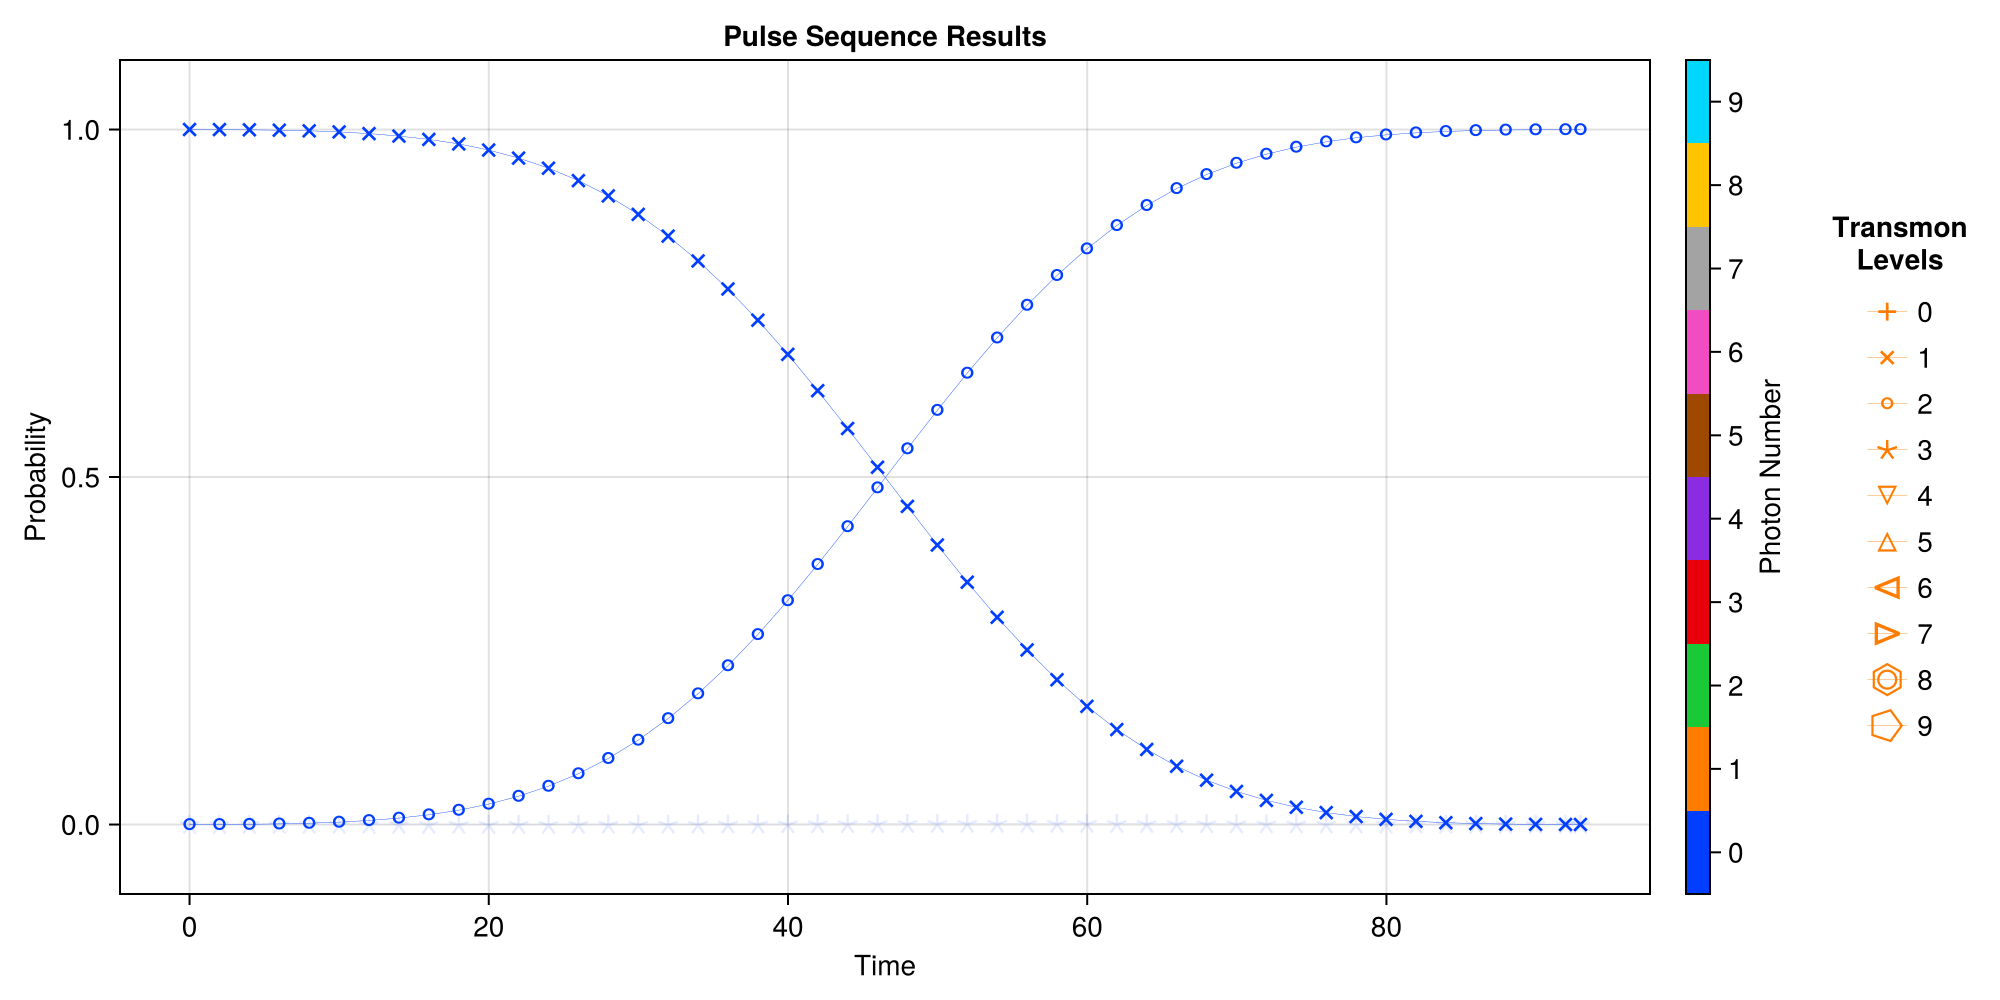

CairoMakie.Screen{IMAGE}


In [69]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ef0_res["times"], EVs_ef0, plot_every = 10, emph_states = [(1,0),(2,0)])

In [70]:
println(EVs_ef0[(0,0)][end])
println(EVs_ef0[(1,0)][end])
println(EVs_ef0[(2,0)][end])
println(EVs_ef0[(3,0)][end])

1.5787458257798495e-5 + 8.586048834460362e-23im
4.69215663774126e-5 + 9.699916770055633e-21im
0.999891769570577 - 4.7893302015206076e-17im
4.2814400127162076e-5 + 7.126072768009789e-22im


In [71]:
tot = 0
for key in keys(EVs_ef0)
    tot+=EVs_ef0[key][end]
end
print(tot)

0.9999972932463406 - 4.833059300705603e-17im

##### $|1,1\rangle \to |2,1\rangle$

In [72]:
state1 = (1,1)
state2 = (2,1)
ψ1 = Mode5.dressed_states[state1]
ψ2 = Mode5.dressed_states[state2]

freq_d = Mode5.dressed_energies[state2]-Mode5.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef1_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-07 20:26:52] Info: On Level 1
[2024-11-07 20:26:52] Info: On Step 1: t = 90.0
[2024-11-07 20:26:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:26:53] Info: Time Evolution Complete
[2024-11-07 20:26:53] Info: Done with Level_1_step_1
[2024-11-07 20:26:53] Info: Accurace: 0.9973603080932794
[2024-11-07 20:26:53] Info: ------------------------------------------------------------------------------
[2024-11-07 20:26:53] Info: On Step 2: t = 92.5
[2024-11-07 20:26:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:26:55] Info: Time Evolution Complete
[2024-11-07 20:26:55] Info: Done with Level_1_step_2
[2024-11-07 20:26:55] Info: Accurace: 0.999830053386331
[2024-11-07 20:26:55] Info: ------------------------------------------------------------------------------
[2024-11-07 20:26:55] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49532

In [73]:
#Mode5.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49532

In [74]:
ψ = Mode5.dressed_states[(1,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef1_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ef_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:27:50.883
It is being saved at: Data/
[2024-11-07 20:27:50] Info: Running operator q_ef_1
[2024-11-07 20:27:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:27:52] Info: Time Evolution Complete
[2024-11-07 20:27:52] Info: Saving Steps
[2024-11-07 20:27:53] Info: Done with Step_1
[2024-11-07 20:27:53] Info: Done With Running Sequence
[2024-11-07 20:27:53] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [75]:
EVs = SC.Utils.Get_EVs(q_ef1_res["states"], proj_dict);

[2024-11-07 20:27:53] Info: Making Plot


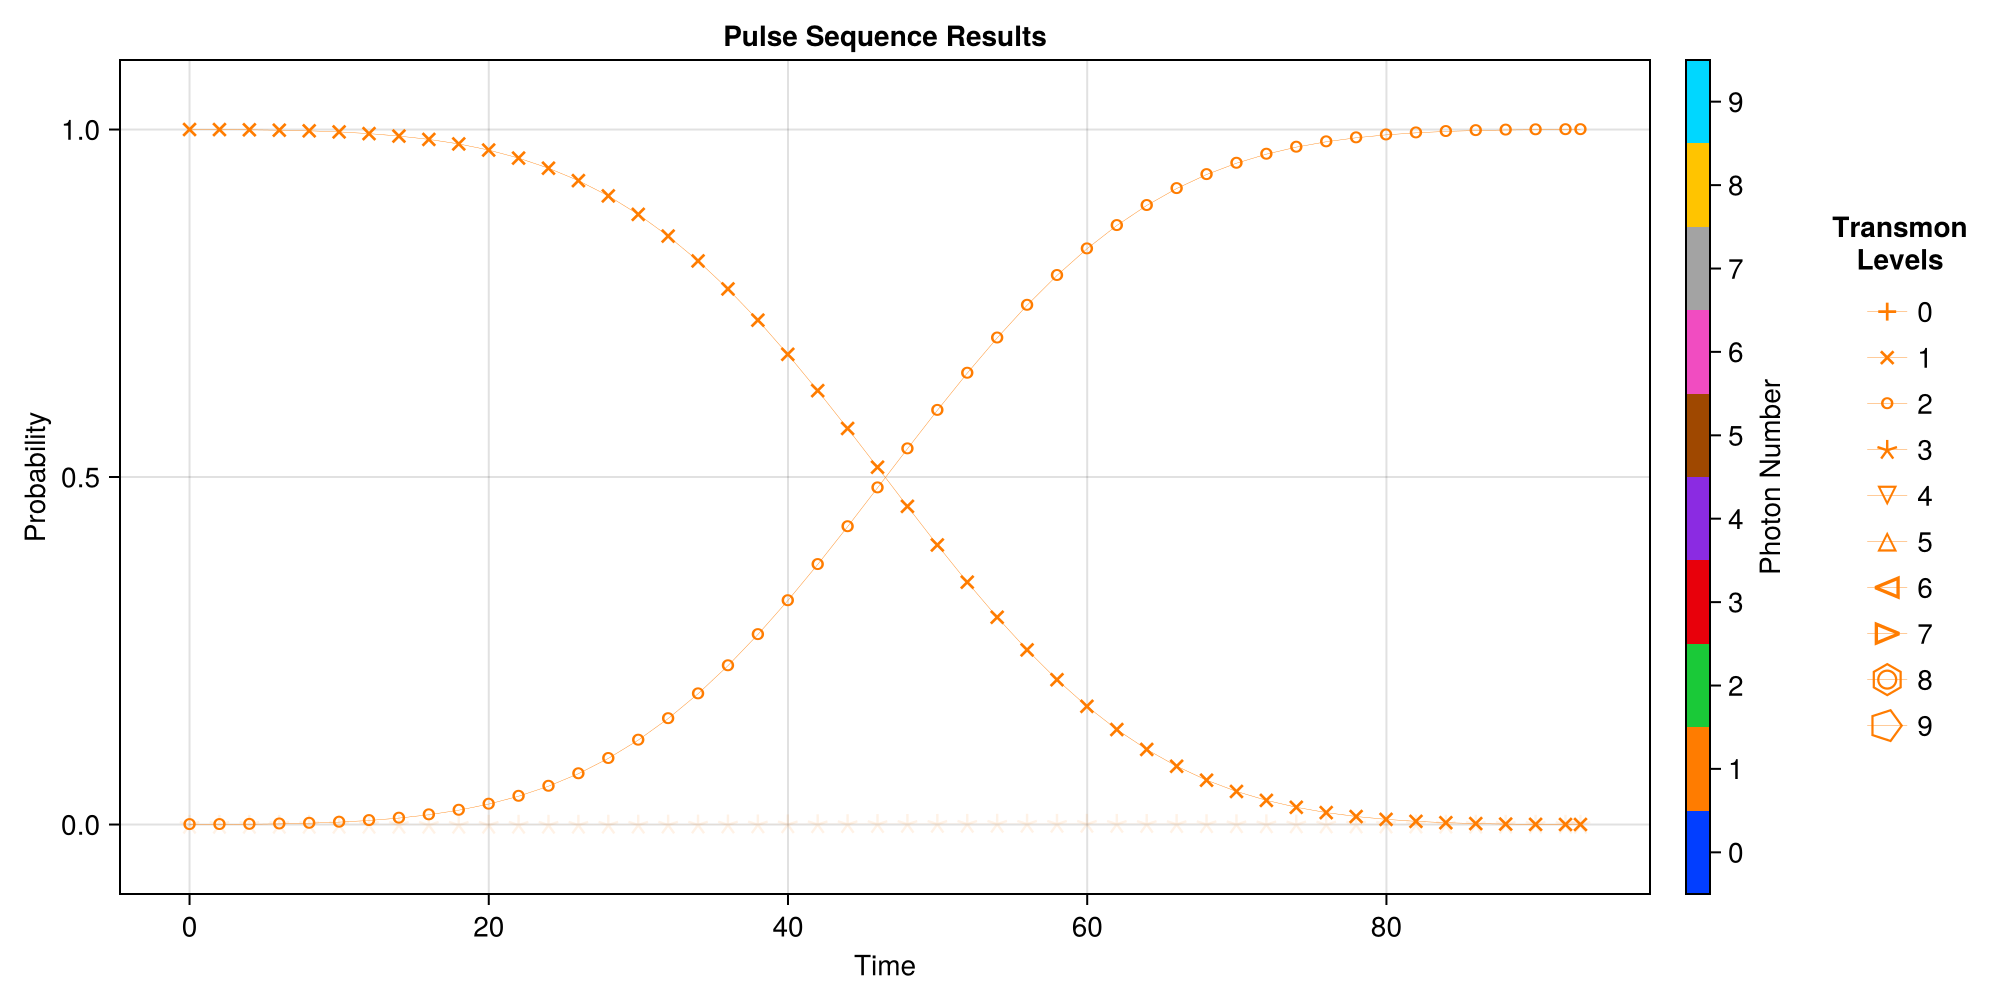

CairoMakie.Screen{IMAGE}


In [76]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ef1_res["times"], EVs, plot_every = 10, emph_states = [(1,1),(2,1)])

In [77]:
EVs[(2,1)][end]

0.9998942245433226 - 1.0929242779829013e-17im

In [78]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997196621737 - 1.0584506190215036e-17im

##### $|1,0\rangle+\frac{1}{\sqrt{2}}\left(|2,0\rangle + |1, 3\rangle\right)\to |2,0\rangle+\frac{1}{\sqrt{2}}\left(|1,0\rangle + |2, 3\rangle\right)$

In [79]:
ψ1 = Mode5.dressed_states[(1,0)]/sqrt(2)+Mode5.dressed_states[(2,0)]+Mode5.dressed_states[(1,3)]/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode5.dressed_states[(2,0)]+(Mode5.dressed_states[(1,0)]+Mode5.dressed_states[(2,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_ef0 = Mode5.dressed_energies[(2,0)]-Mode5.dressed_energies[(1,0)]+ef_stark_shift
freq_d_ef1 = Mode5.dressed_energies[(2,1)]-Mode5.dressed_energies[(1,1)]+ef_stark_shift
freq_d_ef3 = Mode5.dressed_energies[(2,3)]-Mode5.dressed_energies[(1,3)]+ef_stark_shift

χ = freq_d_ef1-freq_d_ef0

freq_d = freq_d_ef0+3*χ/2

check_op = proj_dict[(2,0)]+proj_dict[(1,0)]+proj_dict[(2,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ef_three_halves_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)

[2024-11-07 20:27:53] Info: On Level 1
[2024-11-07 20:27:53] Info: On Step 1: t = 90.0
[2024-11-07 20:27:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:27:55] Info: Time Evolution Complete
[2024-11-07 20:27:55] Info: Done with Level_1_step_1
[2024-11-07 20:27:55] Info: Accurace: 0.9989512878891869
[2024-11-07 20:27:55] Info: ------------------------------------------------------------------------------
[2024-11-07 20:27:55] Info: On Step 2: t = 92.5
[2024-11-07 20:27:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:27:57] Info: Time Evolution Complete
[2024-11-07 20:27:57] Info: Done with Level_1_step_2
[2024-11-07 20:27:57] Info: Accurace: 0.9994824272236538
[2024-11-07 20:27:57] Info: ------------------------------------------------------------------------------
[2024-11-07 20:27:57] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99949
  "freq_d"        => 4.49524

In [80]:
#Mode5.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99949
  "freq_d"        => 4.49524

In [81]:
ψ = Mode5.dressed_states[(1,0)]/sqrt(2)+Mode5.dressed_states[(2,0)]+Mode5.dressed_states[(1,3)]/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ef_three_halves_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ef_3/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:28:43.791
It is being saved at: Data/
[2024-11-07 20:28:43] Info: Running operator q_ef_3/2
[2024-11-07 20:28:43] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:28:46] Info: Time Evolution Complete
[2024-11-07 20:28:46] Info: Saving Steps
[2024-11-07 20:28:46] Info: Done with Step_1
[2024-11-07 20:28:46] Info: Done With Running Sequence
[2024-11-07 20:28:46] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [82]:
EVs = SC.Utils.Get_EVs(q_ef_three_halves_res["states"], proj_dict);

[2024-11-07 20:28:47] Info: Making Plot


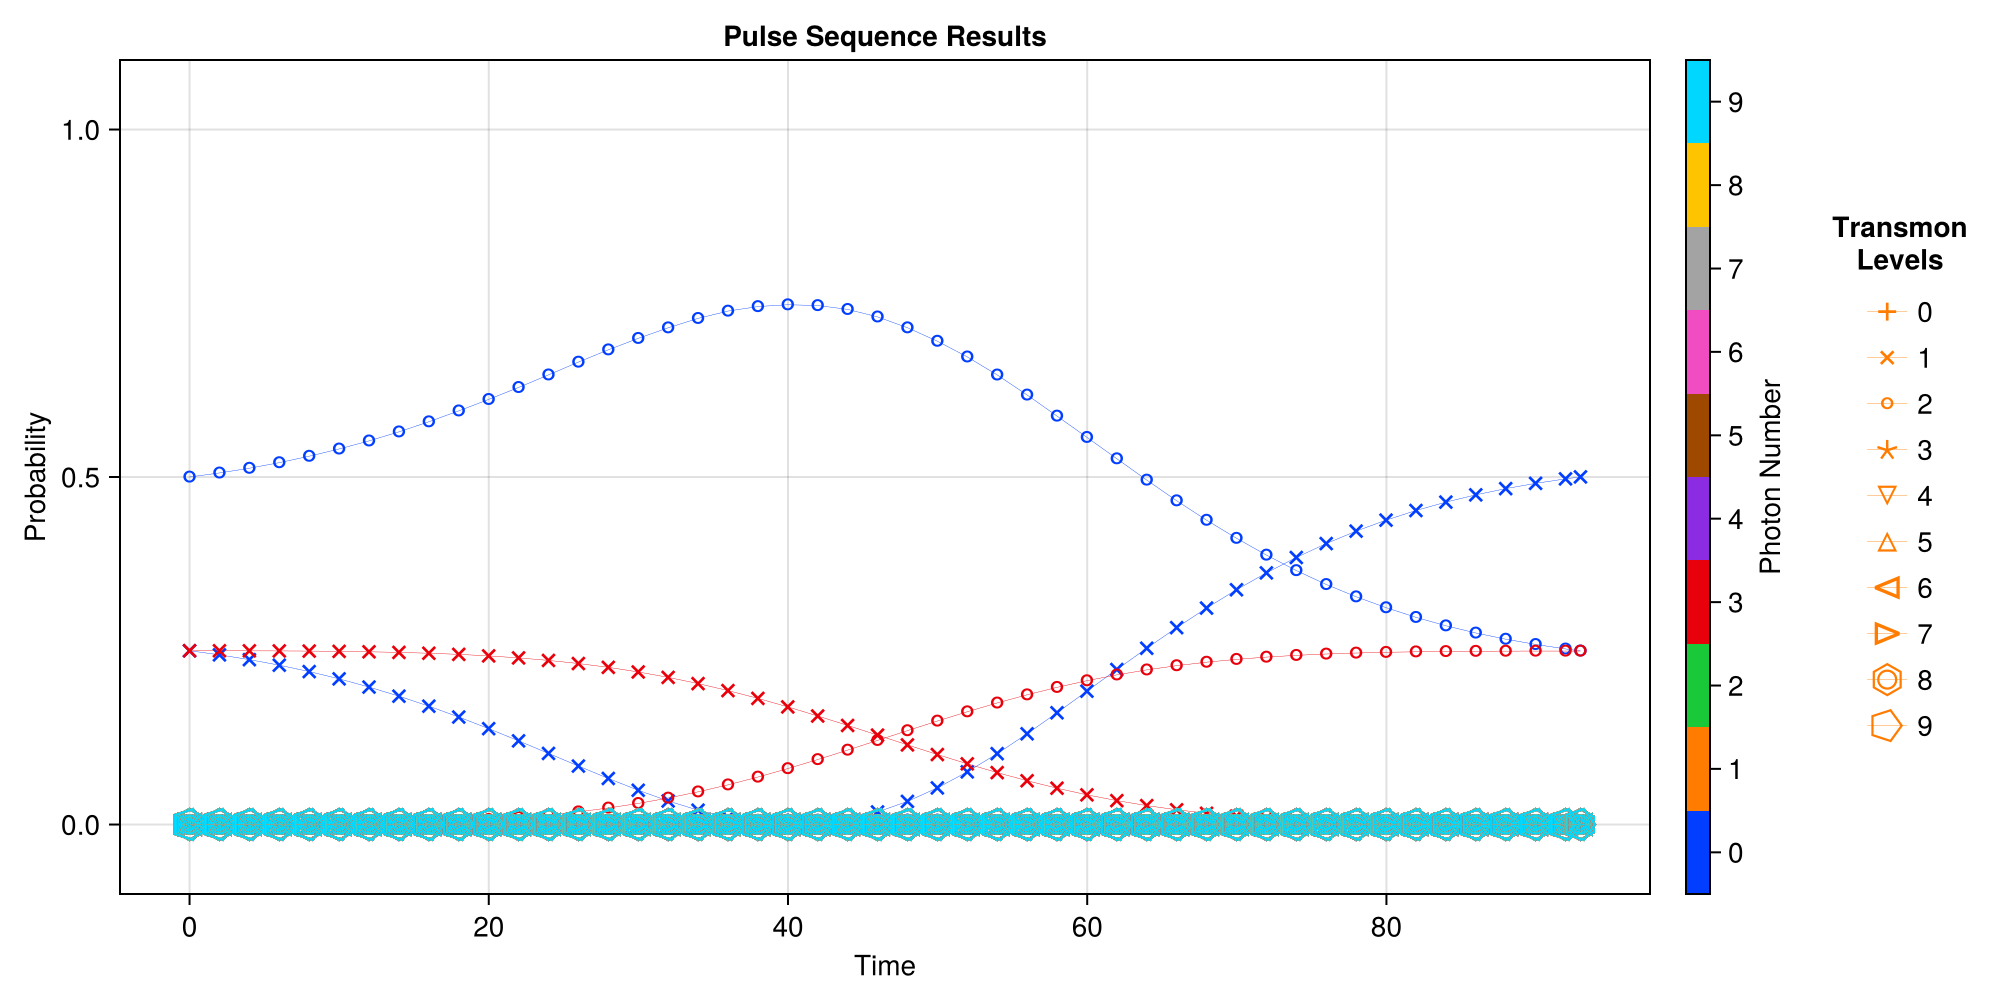

CairoMakie.Screen{IMAGE}


In [83]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ef_three_halves_res["times"], EVs, plot_every = 10)

In [84]:
println(EVs[(2,0)][end])
println(EVs[(1,0)][end])
println(EVs[(2,3)][end])

0.24976160322580254 - 2.615732694370742e-17im
0.500155445280302 - 5.212657524679713e-17im
0.24958158030708952 - 1.2061346752899957e-18im


In [85]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998254027825 - 7.951066912066213e-17im

##### $|1,2\rangle \to |2,2\rangle$

In [86]:
state1 = (1,2)
state2 = (2,2)
ψ1 = Mode5.dressed_states[state1]
ψ2 = Mode5.dressed_states[state2]

freq_d = Mode5.dressed_energies[state2]-Mode5.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef2_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 7)


[2024-11-07 20:28:47] Info: On Level 1
[2024-11-07 20:28:47] Info: On Step 1: t = 90.0
[2024-11-07 20:28:47] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:28:49] Info: Time Evolution Complete
[2024-11-07 20:28:49] Info: Done with Level_1_step_1
[2024-11-07 20:28:49] Info: Accurace: 0.9973581921831606
[2024-11-07 20:28:49] Info: ------------------------------------------------------------------------------
[2024-11-07 20:28:49] Info: On Step 2: t = 92.5
[2024-11-07 20:28:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:28:50] Info: Time Evolution Complete
[2024-11-07 20:28:50] Info: Done with Level_1_step_2
[2024-11-07 20:28:50] Info: Accurace: 0.9998297586471019
[2024-11-07 20:28:50] Info: ------------------------------------------------------------------------------
[2024-11-07 20:28:50] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49516

In [87]:
#Mode5.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49516

In [88]:
ψ = Mode5.dressed_states[(1,2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef2_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ef_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:29:58.225
It is being saved at: Data/
[2024-11-07 20:29:58] Info: Running operator q_ef_2
[2024-11-07 20:29:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:30:00] Info: Time Evolution Complete
[2024-11-07 20:30:00] Info: Saving Steps
[2024-11-07 20:30:01] Info: Done with Step_1
[2024-11-07 20:30:01] Info: Done With Running Sequence
[2024-11-07 20:30:01] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [89]:
EVs = SC.Utils.Get_EVs(q_ef2_res["states"], proj_dict);

[2024-11-07 20:30:01] Info: Making Plot


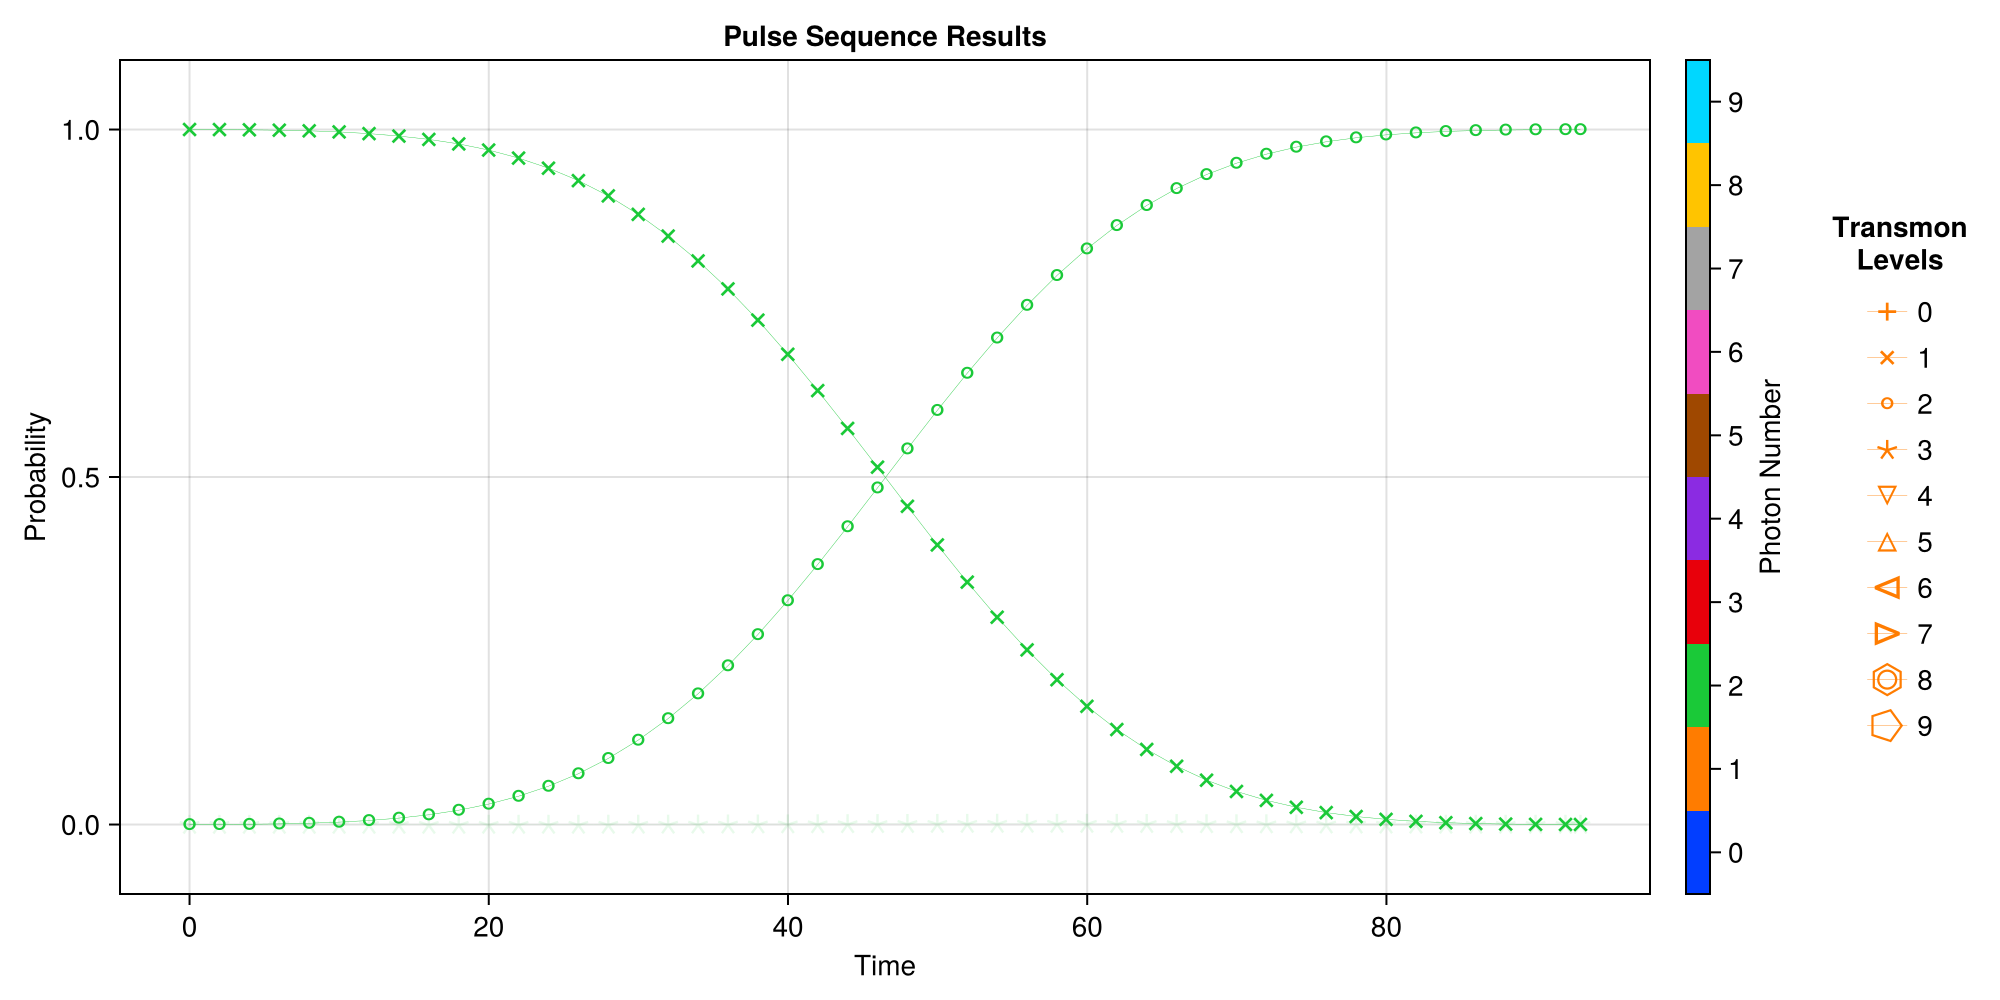

CairoMakie.Screen{IMAGE}


In [90]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ef2_res["times"], EVs, plot_every = 10, emph_states = [(1,2),(2,2)])

In [91]:
EVs[(2,2)][end]

0.9998945274228888 - 5.0988117100682305e-17im

In [92]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999954299157 - 5.240116016431818e-17im

##### $|1,3\rangle \to |2,3\rangle$

In [93]:
state1 = (1,3)
state2 = (2,3)
ψ1 = Mode5.dressed_states[state1]
ψ2 = Mode5.dressed_states[state2]

freq_d = Mode5.dressed_energies[state2]-Mode5.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 110]

qubit_ef3_opt_res = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-07 20:30:01] Info: On Level 1
[2024-11-07 20:30:01] Info: On Step 1: t = 90.0
[2024-11-07 20:30:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:30:03] Info: Time Evolution Complete
[2024-11-07 20:30:03] Info: Done with Level_1_step_1
[2024-11-07 20:30:03] Info: Accurace: 0.9973558996342444
[2024-11-07 20:30:03] Info: ------------------------------------------------------------------------------
[2024-11-07 20:30:03] Info: On Step 2: t = 95.0
[2024-11-07 20:30:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:30:05] Info: Time Evolution Complete
[2024-11-07 20:30:05] Info: Done with Level_1_step_2
[2024-11-07 20:30:05] Info: Accurace: 0.9987329913209102
[2024-11-07 20:30:05] Info: ------------------------------------------------------------------------------
[2024-11-07 20:30:05] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999889
  "freq_d"        => 4.495

In [94]:
#Mode5.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999889
  "freq_d"        => 4.495

In [95]:
ψ = Mode5.dressed_states[(1,3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef3_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_ef_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T20:30:53.109
It is being saved at: Data/
[2024-11-07 20:30:53] Info: Running operator q_ef_3
[2024-11-07 20:30:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:30:55] Info: Time Evolution Complete
[2024-11-07 20:30:55] Info: Saving Steps
[2024-11-07 20:30:56] Info: Done with Step_1
[2024-11-07 20:30:56] Info: Done With Running Sequence
[2024-11-07 20:30:56] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [96]:
EVs = SC.Utils.Get_EVs(q_ef3_res["states"], proj_dict);

[2024-11-07 20:30:56] Info: Making Plot


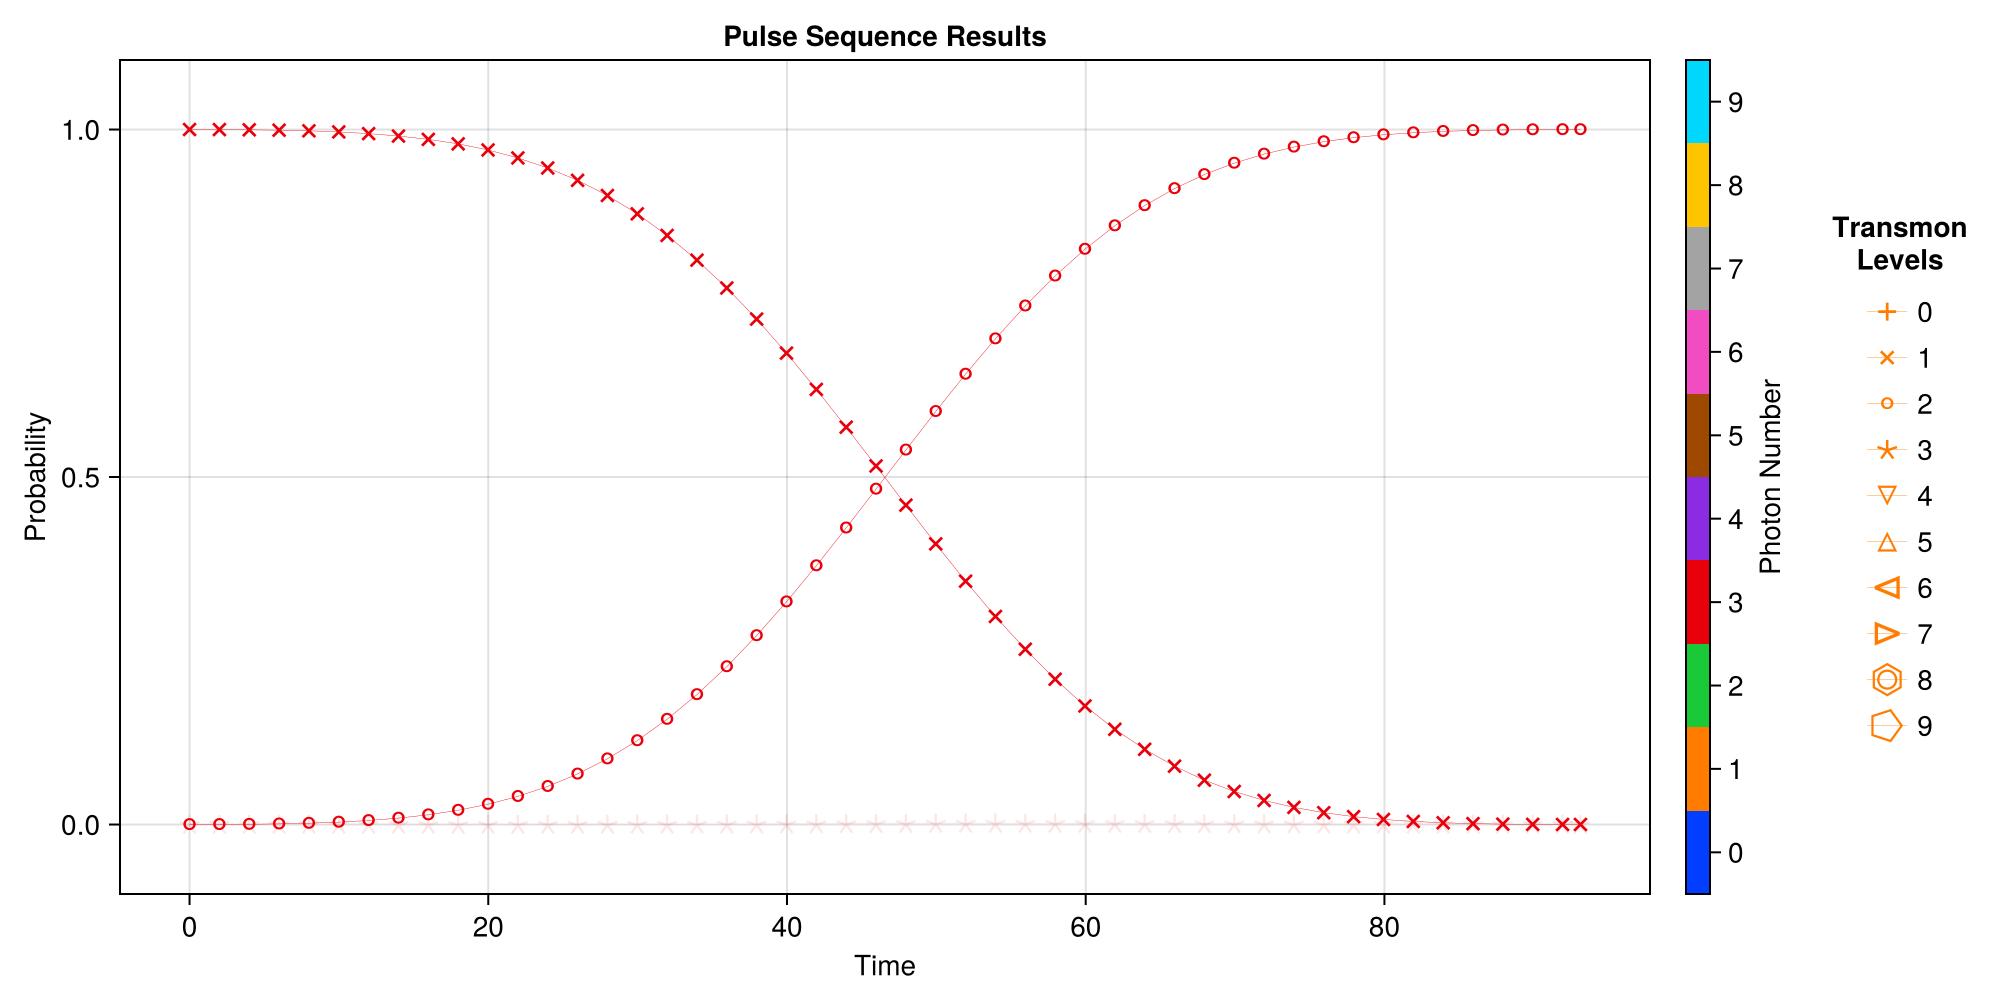

CairoMakie.Screen{IMAGE}


In [97]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, q_ef3_res["times"], EVs, plot_every = 10, emph_states = [(1,3),(2,3)])

In [98]:
EVs[(2, 3)][end]

0.9998887393532154 - 2.5694708899780163e-18im

In [99]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
tot

0.999999999994923 - 1.5200510849876915e-18im

### Half Qubit $|g0\rangle \to |g0\rangle+|e0\rangle$

In [100]:
starting_args = deepcopy(Mode5.Stuff["op_drive_params"]["q_ge_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode5.dressed_states[(0,0)]
ψ2 = Mode5.dressed_states[(0,0)] + Mode5.dressed_states[(1,0)]
ψ2 = ψ2/sqrt(2)

op = Mode5.dressed_states[(0,0)]*Mode5.dressed_states[(1,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_g0e0 = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-11-07 20:30:56] Info: On Level 1
[2024-11-07 20:30:56] Info: On Step 1: t = 92.96875
[2024-11-07 20:30:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:30:58] Info: Time Evolution Complete
[2024-11-07 20:30:58] Info: Done with Level_1_step_1
[2024-11-07 20:30:58] Info: Accurace: 0.9995677934797847
[2024-11-07 20:30:58] Info: ------------------------------------------------------------------------------
[2024-11-07 20:30:58] Info: Highest Accuracy: 0.9995677934797847
[2024-11-07 20:30:58] Info: New ti: 92.96875, new tf: 92.96875
[2024-11-07 20:30:58] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999568
  "freq_d"        => 4.60394

In [101]:
#Mode5.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999568
  "freq_d"        => 4.60394

In [102]:
ψ = Mode5.dressed_states[(0,0)]
res_half_ge0 = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["q_half_ge0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-07T20:30:58.687
It is being saved at: Data/
[2024-11-07 20:30:58] Info: Running operator q_half_ge0
[2024-11-07 20:30:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 20:31:00] Info: Time Evolution Complete
[2024-11-07 20:31:00] Info: Saving Steps
[2024-11-07 20:31:01] Info: Done with Step_1
[2024-11-07 20:31:01] Info: Done With Running Sequence
[2024-11-07 20:31:01] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [103]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ge0["states"], proj_dict);

[2024-11-07 20:31:01] Info: Making Plot


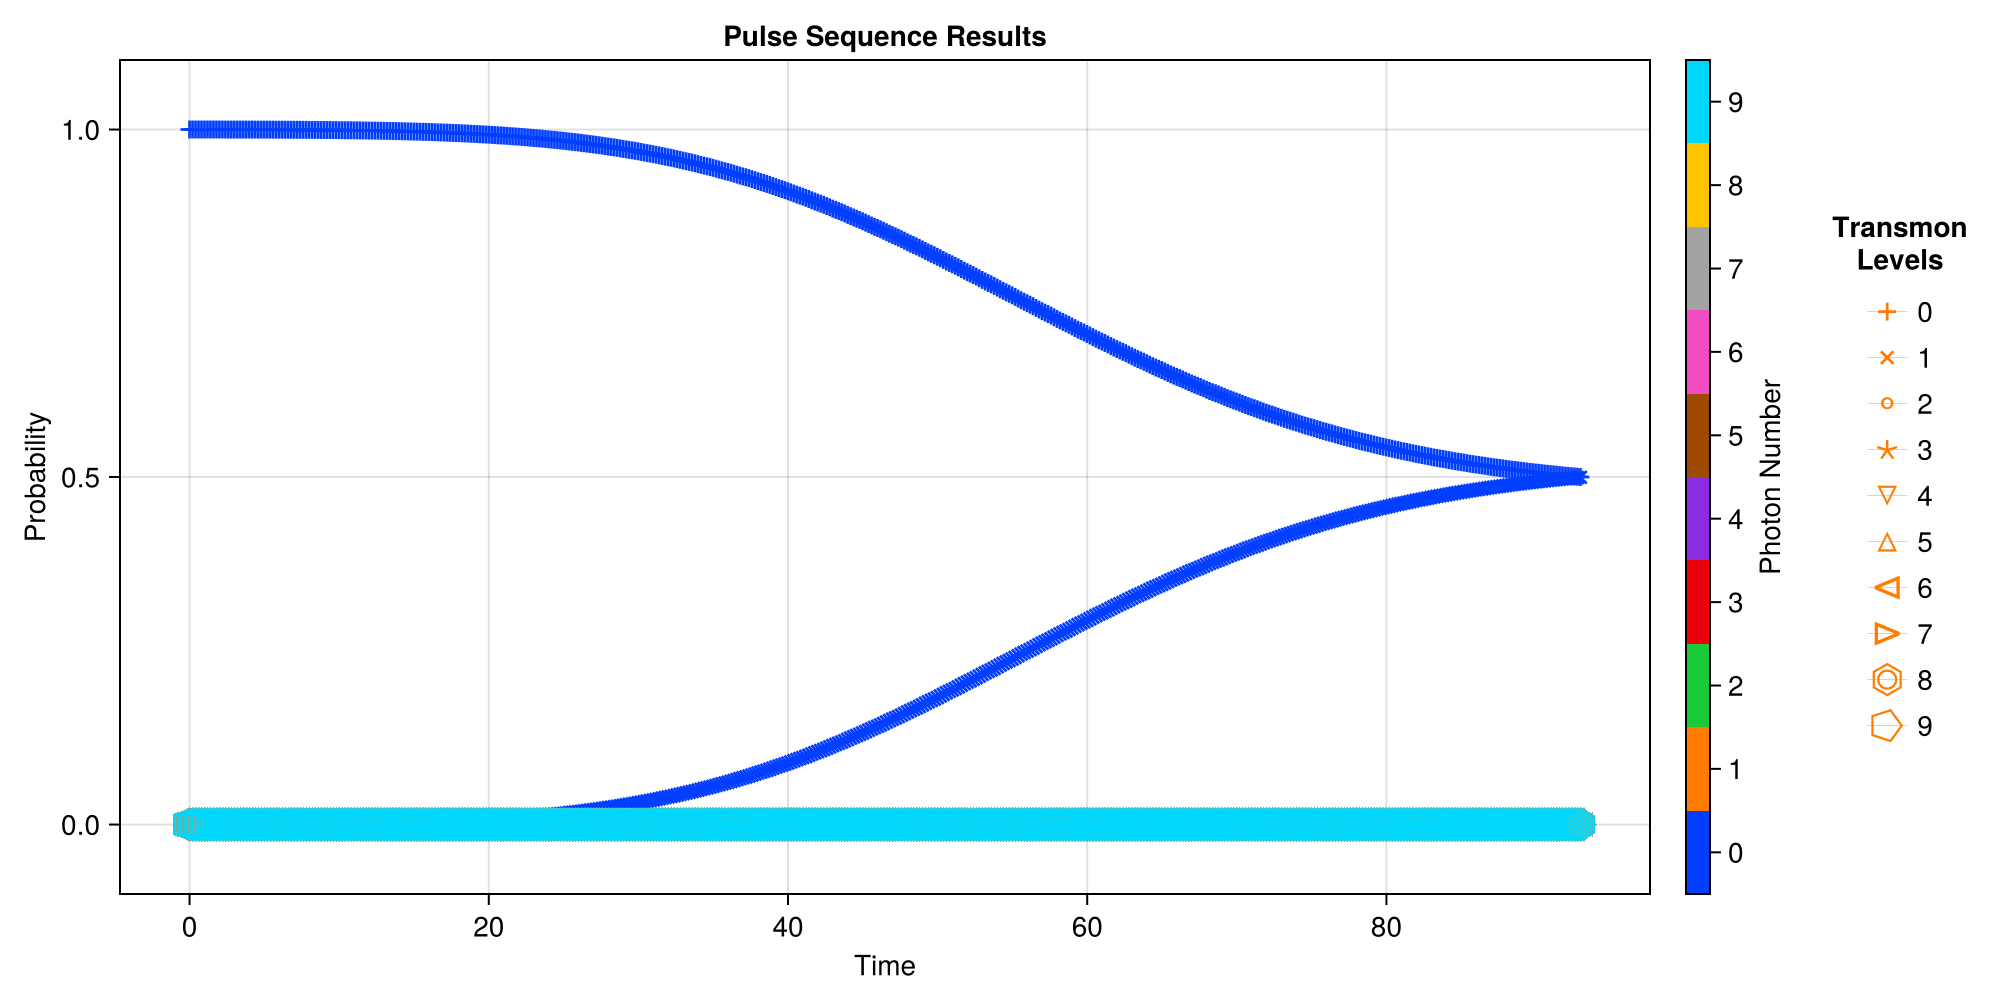

In [104]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, res_half_ge0["times"], EVs_Dict);

In [105]:
println(EVs_Dict[(0,0)][end])
println(EVs_Dict[(1,0)][end])

0.5000036468444541 + 1.3616579186625913e-17im
0.49956424321484305 - 5.163317062853625e-17im


## Sidebands at $\varepsilon = 1.21$

### Getting Stark Shift

[2024-11-07 22:20:12] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


[2024-11-07 22:20:30] Info: Done With Floquet Sweep
[2024-11-07 22:20:32] Info: Fit Stuff: 3-element Vector{Float64}:	 0.04653811211348203	 0.0025187847136094294	 2.1447528969498695
Stark shift res: [0.04653811211348203, 185.1107702679405]


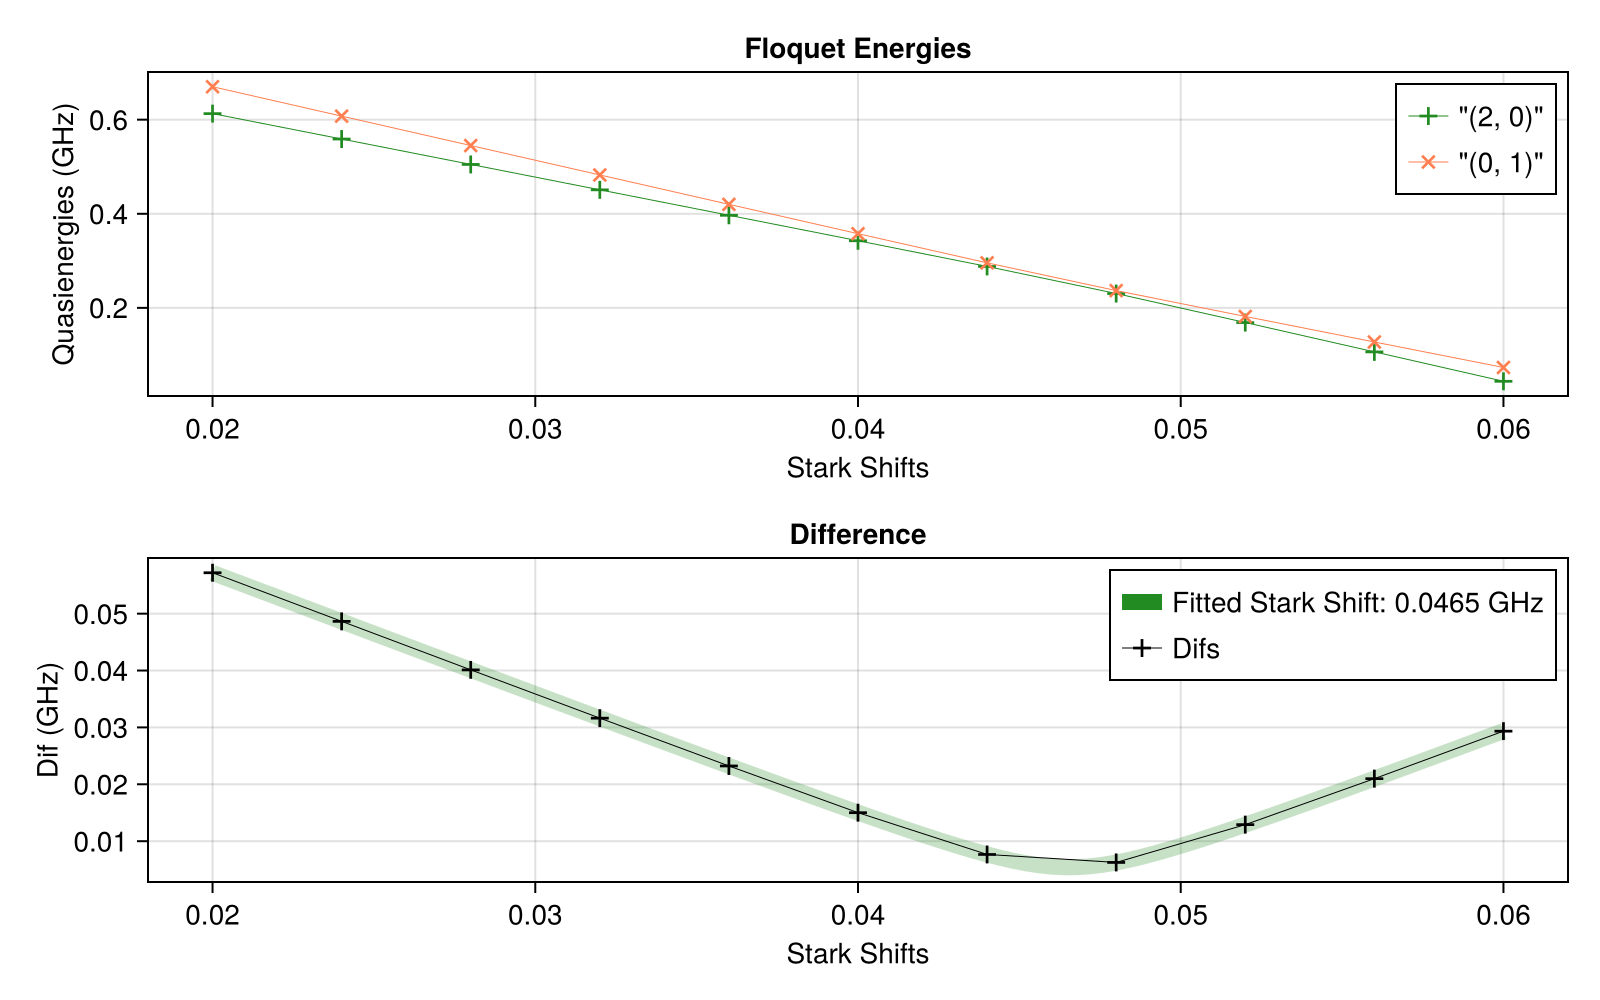

In [5]:
fngnp1_ε = 1.21
drive_op = Mode5.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.02, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode5, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [6]:
fngnp1_ramp_time = 11.6257;

### f0->g1


In [7]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][5][1]*1000))

Target flattop time: 174.38616071428572


In [8]:
ψ1 = Mode5.dressed_states[(2,0)]
ψ2 = Mode5.dressed_states[(0,1)]

freq_d = Mode5.dressed_energies[(0,1)]-Mode5.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-07 22:20:44] Info: On Level 1
[2024-11-07 22:20:44] Info: On Step 1: t = 185.1107702679405
[2024-11-07 22:20:44] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-07 22:20:51] Info: Time Evolution Complete
[2024-11-07 22:20:51] Info: Done with Level_1_step_1
[2024-11-07 22:20:51] Info: Accurace: 0.989253992309391
[2024-11-07 22:20:51] Info: ------------------------------------------------------------------------------
[2024-11-07 22:20:51] Info: On Step 2: t = 190.92362026794046
[2024-11-07 22:20:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-07 22:20:55] Info: Time Evolution Complete
[2024-11-07 22:20:55] Info: Done with Level_1_step_2
[2024-11-07 22:20:55] Info: Accurace: 0.9968154283882574
[2024-11-07 22:20:55] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 197.1
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>197.1, "k"=>2, "ramp_time"=>1…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 0.999527
  "freq_d"        => -2.37723

In [9]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

173.84837339294052

In [10]:
#Mode5.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 197.1
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>197.1, "k"=>2, "ramp_time"=>1…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 0.999527
  "freq_d"        => -2.37723

In [11]:
ψ = Mode5.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T22:22:35.469
It is being saved at: Data/
[2024-11-07 22:22:35] Info: Running operator sb_f0g1
[2024-11-07 22:22:35] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-07 22:22:39] Info: Time Evolution Complete
[2024-11-07 22:22:39] Info: Saving Steps
[2024-11-07 22:22:44] Info: Done with Step_1
[2024-11-07 22:22:44] Info: Done With Running Sequence
[2024-11-07 22:22:44] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199898, 0.399797, 0.599695, 0.799593, 0.999492, 1.1993…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [12]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

[2024-11-07 22:22:48] Info: Making Plot


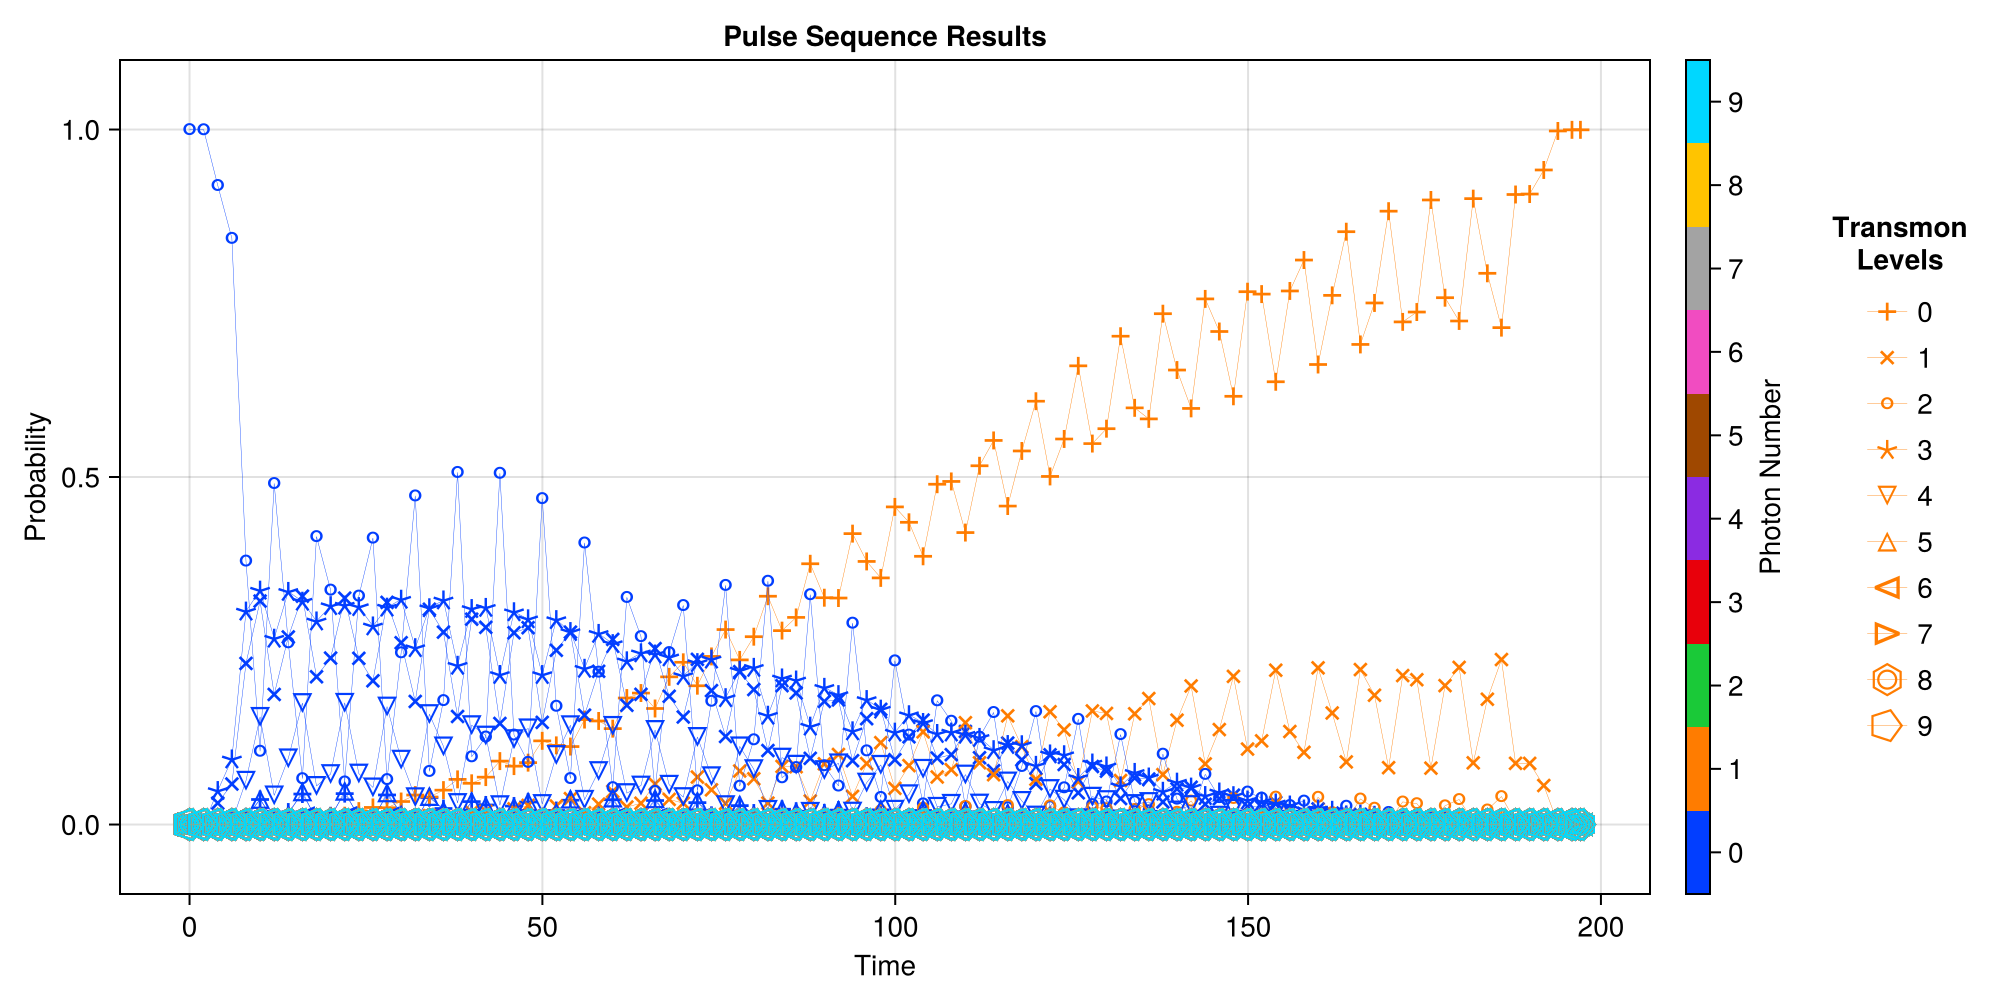

CairoMakie.Screen{IMAGE}


In [13]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

### f1->g2


In [14]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][5][2]*1000))

Target flattop time: 123.2328869047619


In [15]:
ψ1 = Mode5.dressed_states[(2,1)]
ψ2 = Mode5.dressed_states[(0,2)]

freq_d = Mode5.dressed_energies[(0,2)]-Mode5.dressed_energies[(2,1)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)


t_range = [fngnp1_start_time/sqrt(2), fngnp1_start_time/sqrt(2)+fngnp1_ramp_time*2]


optimize_res_f1g2 = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-07 22:22:53] Info: On Level 1
[2024-11-07 22:22:53] Info: On Step 1: t = 130.89308092712585
[2024-11-07 22:22:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 22:22:56] Info: Time Evolution Complete
[2024-11-07 22:22:56] Info: Done with Level_1_step_1
[2024-11-07 22:22:56] Info: Accurace: 0.9775328143694635
[2024-11-07 22:22:56] Info: ------------------------------------------------------------------------------
[2024-11-07 22:22:56] Info: On Step 2: t = 136.70593092712585
[2024-11-07 22:22:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 22:22:59] Info: Time Evolution Complete
[2024-11-07 22:22:59] Info: Done with Level_1_step_2
[2024-11-07 22:22:59] Info: Accurace: 0.9928065195053419
[2024-11-07 22:22:59] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 142.882
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>142.882, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 0.998475
  "freq_d"        => -2.3769

In [16]:
optimize_res_f1g2["pulse_time"]-optimize_res_f1g2["Envelope Args"]["ramp_time"]*2

119.63068405212583

In [17]:
#Mode5.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 142.882
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>142.882, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 0.998475
  "freq_d"        => -2.3769

### f2->g3

In [18]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][5][3]*1000))

Target flattop time: 99.98139880952381


In [19]:
ψ1 = Mode5.dressed_states[(2,2)]
ψ2 = Mode5.dressed_states[(0,3)]

freq_d = Mode5.dressed_energies[(0,3)]-Mode5.dressed_energies[(2,2)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(3), fngnp1_start_time/sqrt(3)+fngnp1_ramp_time*2]

optimize_res_f2g3 = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-07 22:24:09] Info: On Level 1
[2024-11-07 22:24:09] Info: On Step 1: t = 106.87375304409443
[2024-11-07 22:24:09] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 22:24:11] Info: Time Evolution Complete
[2024-11-07 22:24:11] Info: Done with Level_1_step_1
[2024-11-07 22:24:11] Info: Accurace: 0.9657782825328155
[2024-11-07 22:24:11] Info: ------------------------------------------------------------------------------
[2024-11-07 22:24:11] Info: On Step 2: t = 112.68660304409443
[2024-11-07 22:24:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 22:24:13] Info: Time Evolution Complete
[2024-11-07 22:24:13] Info: Done with Level_1_step_2
[2024-11-07 22:24:13] Info: Accurace: 0.9887103823554388
[2024-11-07 22:24:13] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 118.863
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>118.863, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 0.997363
  "freq_d"        => -2.37656

In [20]:
optimize_res_f2g3["pulse_time"]-optimize_res_f2g3["Envelope Args"]["ramp_time"]*2

95.61135616909442

In [21]:
#Mode5.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 118.863
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>118.863, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 0.997363
  "freq_d"        => -2.37656

### f3->g4

In [22]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][5][4]*1000))

Target flattop time: 83.70535714285714


In [23]:
ψ1 = Mode5.dressed_states[(2,3)]
ψ2 = Mode5.dressed_states[(0,4)]

freq_d = Mode5.dressed_energies[(0,4)]-Mode5.dressed_energies[(2,3)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(4), fngnp1_start_time/sqrt(4)+fngnp1_ramp_time*2]

optimize_res_f3g4 = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-07 22:25:19] Info: On Level 1
[2024-11-07 22:25:19] Info: On Step 1: t = 92.55538513397025
[2024-11-07 22:25:19] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 22:25:22] Info: Time Evolution Complete
[2024-11-07 22:25:22] Info: Done with Level_1_step_1
[2024-11-07 22:25:22] Info: Accurace: 0.9540739385585113
[2024-11-07 22:25:22] Info: ------------------------------------------------------------------------------
[2024-11-07 22:25:22] Info: On Step 2: t = 98.36823513397024
[2024-11-07 22:25:22] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 22:25:24] Info: Time Evolution Complete
[2024-11-07 22:25:24] Info: Done with Level_1_step_2
[2024-11-07 22:25:24] Info: Accurace: 0.9845934668436772
[2024-11-07 22:25:24] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 104.908
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>104.908, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 0.996242
  "freq_d"        => -2.37622

In [24]:
optimize_res_f3g4["pulse_time"]-optimize_res_f3g4["Envelope Args"]["ramp_time"]*2

81.65629138397024

In [25]:
#Mode5.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 104.908
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>104.908, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 0.996242
  "freq_d"        => -2.37622

## Other Specific Gates

### Special Side Bands

#### f1_2pi_g3

##### Getting Drive Strength and Stark Shift

In [26]:
n1 = 1
n2 = 3

freq1 = Mode5.dressed_energies[(2,n1)]-Mode5.dressed_energies[(0,n1+1)]
freq2 = Mode5.dressed_energies[(2,n2)]-Mode5.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f1_2pi_g3 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.4
println("Required Epsilon: $eps_f1_2pi_g3")

χ: 0.0006735741571213261
m: 1.4142135623730951
n: 1
Required Epsilon: 0.09525777082650055


[2024-11-07 22:26:25] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


[2024-11-07 22:26:37] Info: Done With Floquet Sweep
[2024-11-07 22:26:37] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00030343922137405	 0.00030943407981759744	 2.000915916563912


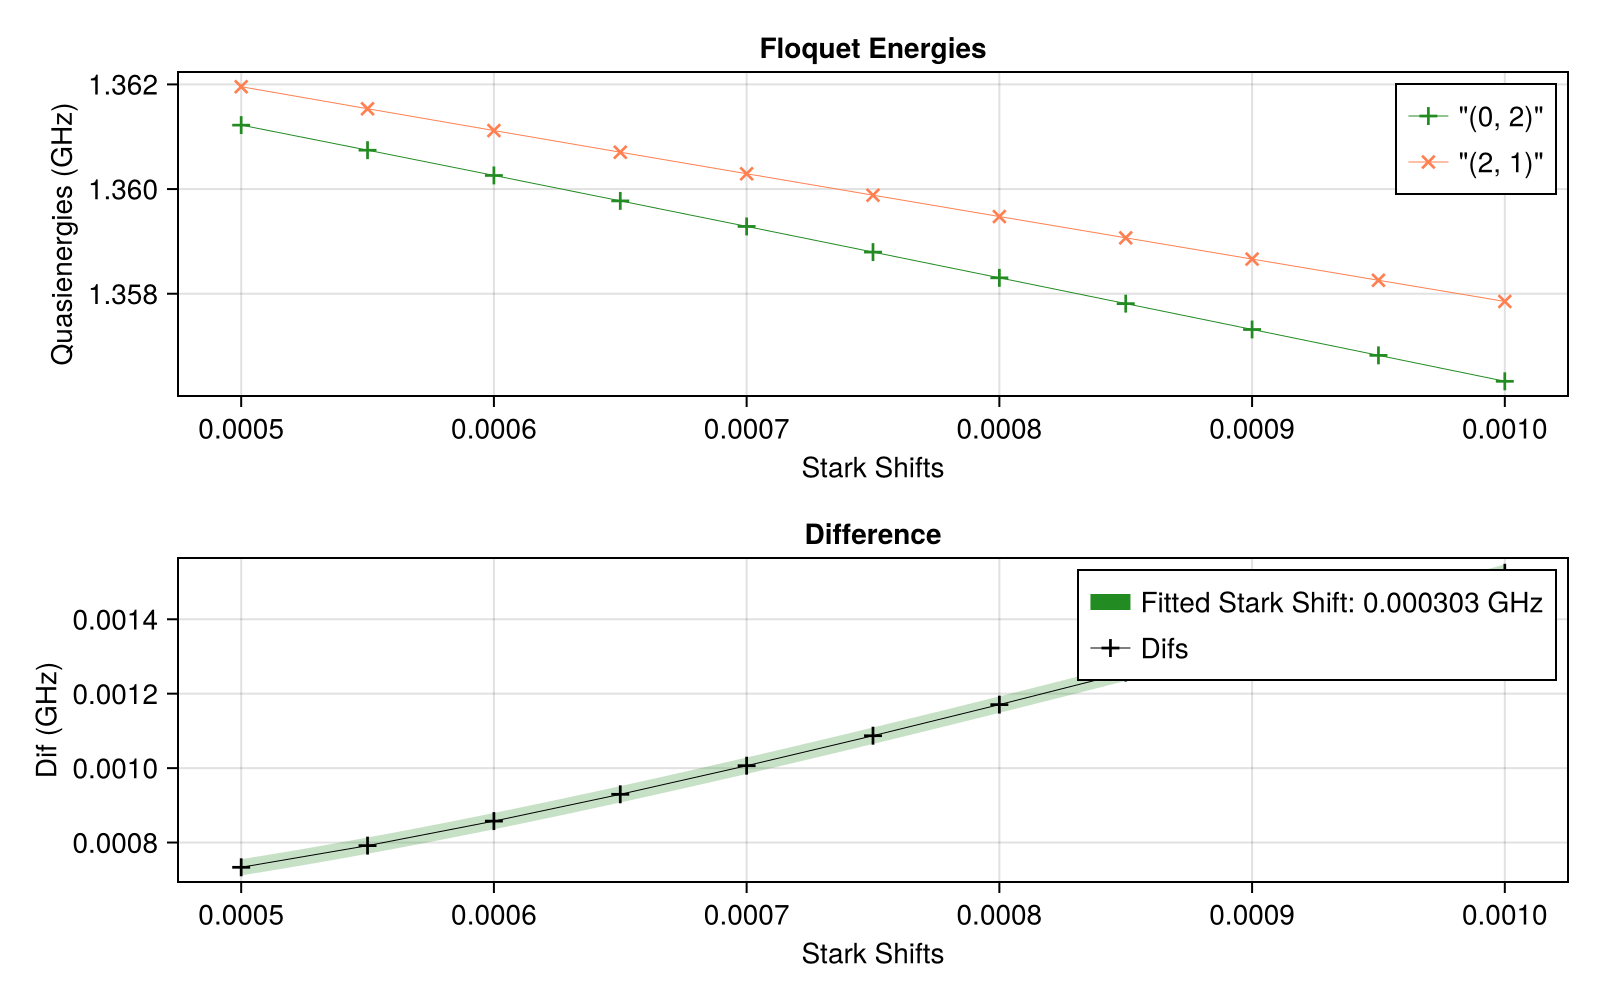

2-element Vector{Float64}:
    0.00030343922137405
 1615.1133901234023

In [27]:
ε = eps_f1_2pi_g3
drive_op = Mode5.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

#stark_shift_list = collect(LinRange(0.0005, 0.002, 11))
stark_shift_list = collect(LinRange(0.0005, 0.001, 11))

stark_shift_res_f0_2pi_g3 = SC.Dynamics.FindStarkShift(Mode5, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [28]:
ψ1 = Mode5.dressed_states[(2,n1)]
ψ2 = Mode5.dressed_states[(0,n1+1)]

freq_d = Mode5.dressed_energies[(0,n1+1)]-Mode5.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)


stark_shift = stark_shift_res_f0_2pi_g3[1]
initial_time = stark_shift_res_f0_2pi_g3[2]

t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f1g2_2pi_f3g4 = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, eps_f1_2pi_g3, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1)

[2024-11-07 22:26:37] Info: On Level 1
[2024-11-07 22:26:37] Info: On Step 1: t = 1615.1133901234023
[2024-11-07 22:26:37] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 39s (ETA: 0h 00m 00s)
[2024-11-07 22:27:17] Info: Time Evolution Complete
[2024-11-07 22:27:17] Info: Done with Level_1_step_1
[2024-11-07 22:27:17] Info: Accurace: 0.9998674656817578
[2024-11-07 22:27:17] Info: ------------------------------------------------------------------------------
[2024-11-07 22:27:17] Info: On Step 2: t = 1620.9262401234023
[2024-11-07 22:27:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 39s (ETA: 0h 00m 00s)
[2024-11-07 22:27:56] Info: Time Evolution Complete
[2024-11-07 22:27:56] Info: Done with Level_1_step_2
[2024-11-07 22:27:56] Info: Accurace: 0.9999654534426039
[2024-11-07 22:27:56] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1626.74
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1626.74, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0952578
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000303439
  "accuracy"      => 1.0
  "freq_d"        => -2.3769

In [29]:
optimize_res_f1g2_2pi_f3g4["pulse_time"] - optimize_res_f1g2_2pi_f3g4["Envelope Args"]["ramp_time"]*2

1603.4876901234022

In [30]:
#Mode5.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1626.74
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1626.74, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0952578
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000303439
  "accuracy"      => 1.0
  "freq_d"        => -2.3769

In [31]:
ψ = Mode5.dressed_states[(2,1)]+Mode5.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f1g2_2pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["sb_f1g2_2pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-07T22:30:00.649
It is being saved at: Data/
[2024-11-07 22:30:00] Info: Running operator sb_f1g2_2pi_f3g4
[2024-11-07 22:30:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 42s (ETA: 0h 00m 00s)
[2024-11-07 22:30:43] Info: Time Evolution Complete
[2024-11-07 22:30:43] Info: Saving Steps
[2024-11-07 22:30:47] Info: Done with Step_1
[2024-11-07 22:30:47] Info: Done With Running Sequence
[2024-11-07 22:30:47] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199993, 0.399985, 0.599978, 0.79997, 0.999963, 1.19996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [32]:
EVs_Dict = SC.Utils.Get_EVs(res_f1g2_2pi_f3g4["states"], proj_dict);

[2024-11-07 22:30:51] Info: Making Plot


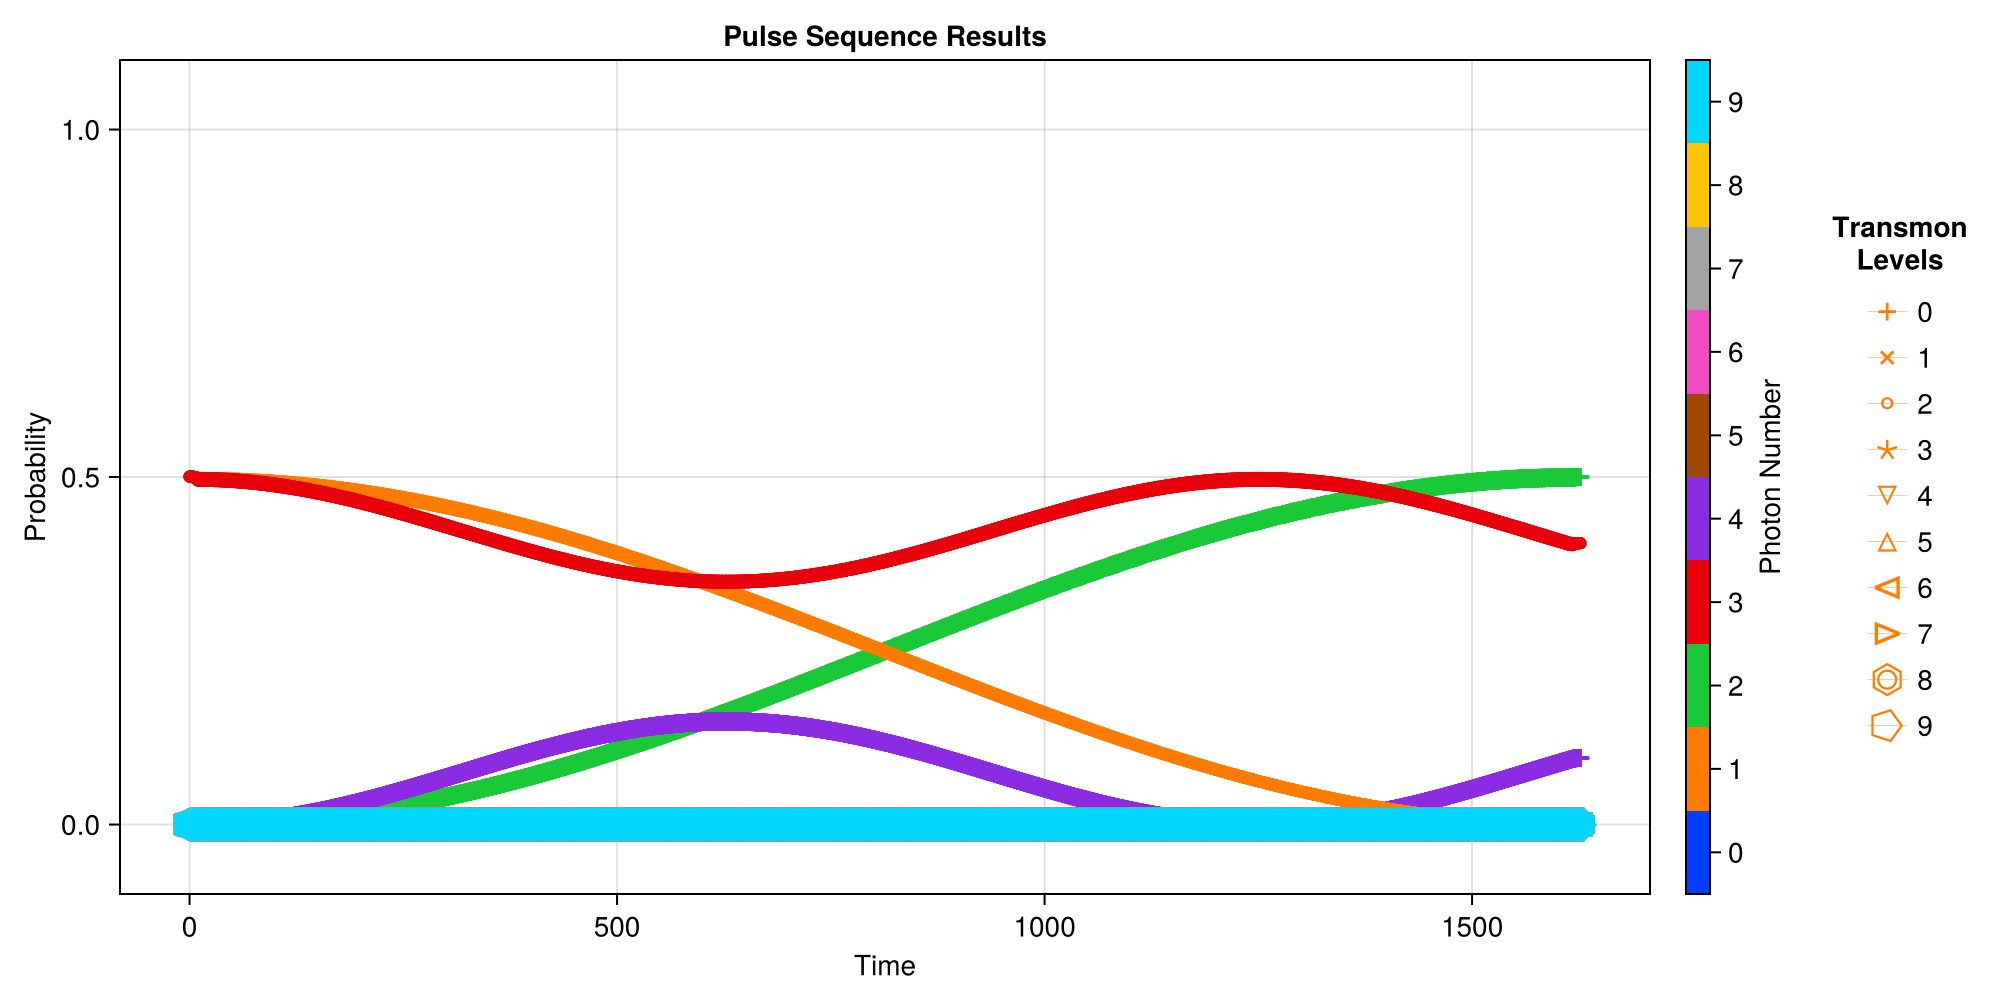

CairoMakie.Screen{IMAGE}


In [33]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, res_f1g2_2pi_f3g4["times"], EVs_Dict)

In [34]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,2)][end])

0.40420927266907924 - 1.0652954325355787e-16im
0.49999957232906617 - 3.7643344768168925e-19im


#### f0_4pi_g3

##### Getting Drive Strength and Stark Shift

In [5]:
n1 = 0
n2 = 3

freq1 = Mode5.dressed_energies[(2,n1)]-Mode5.dressed_energies[(0,n1+1)]
freq2 = Mode5.dressed_energies[(2,n2)]-Mode5.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f0g1_4pi_f3g4 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.56
println("Required Epsilon: $eps_f0g1_4pi_f3g4")

χ: 0.0010104238366115403
m: 2.0000000000000004
n: 2
Required Epsilon: 0.08167158636886022


[2024-11-07 22:46:47] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


[2024-11-07 22:47:03] Info: Done With Floquet Sweep


Progress:  18%|███████▌                                 |  ETA: 0:00:00

[2024-11-07 22:47:04] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00022327431474131236	 0.00018766618379154965	 2.0006728735989046


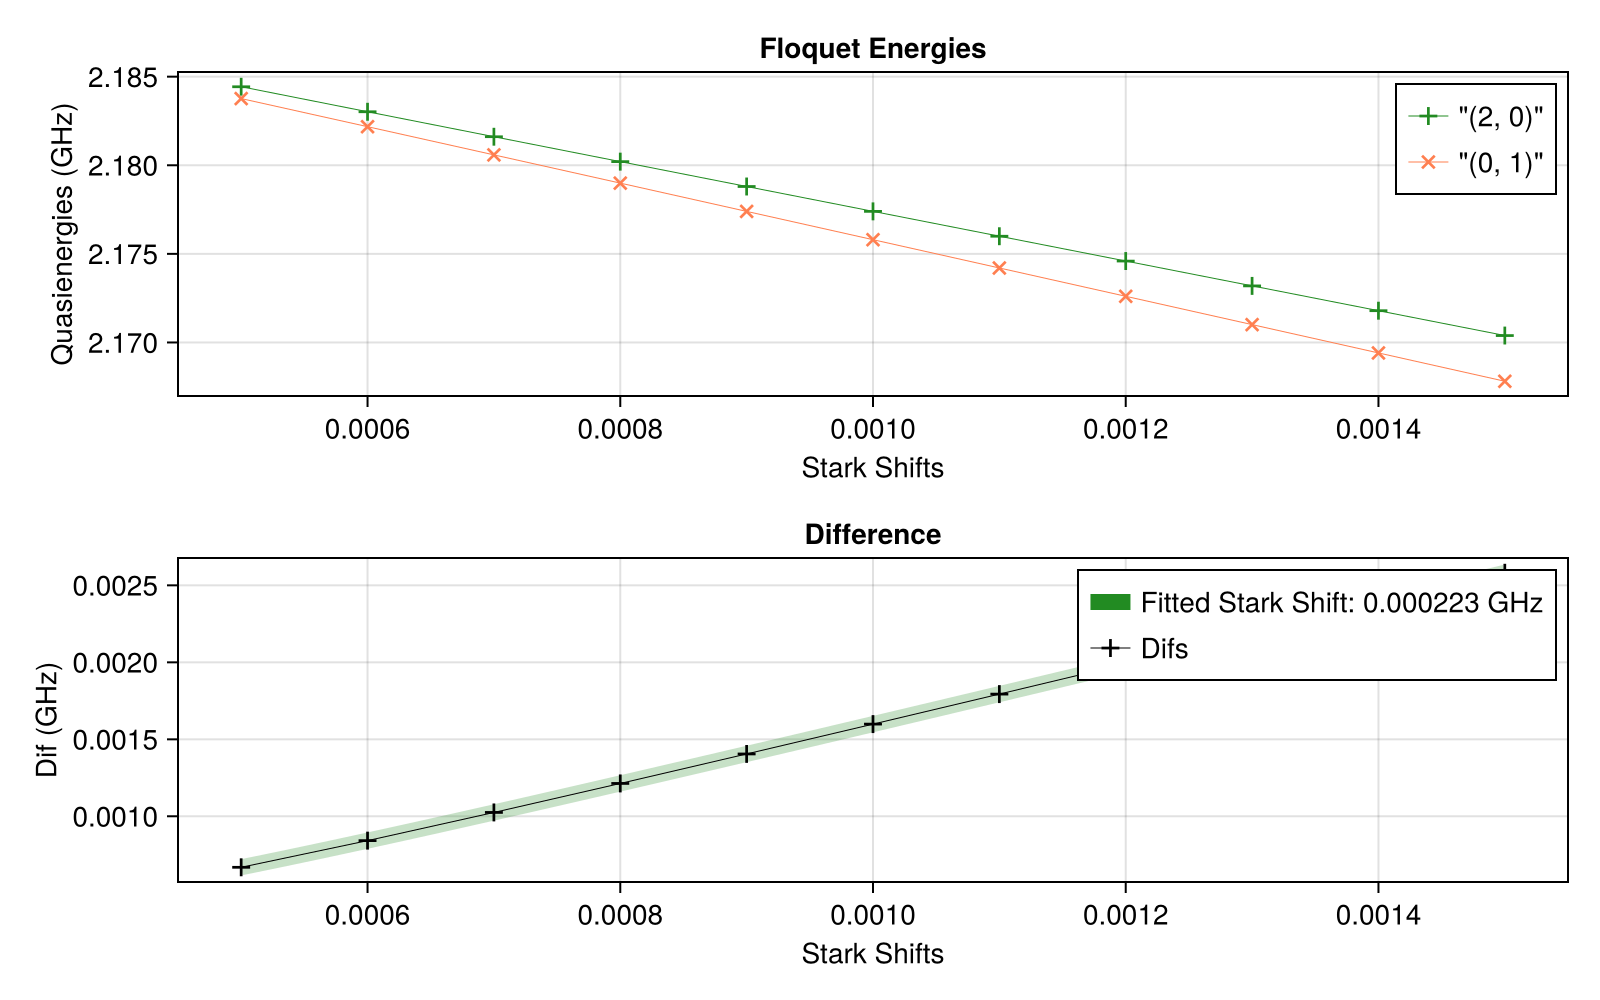

2-element Vector{Float64}:
    0.00022327431474131236
 2663.4091879402645

In [6]:
ε = eps_f0g1_4pi_f3g4
drive_op = Mode5.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

stark_shift_list = collect(LinRange(0.0005, 0.0015, 11))

stark_shift_res_f0g1_4pi_f3g4 = SC.Dynamics.FindStarkShift(Mode5, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [7]:
ψ1 = Mode5.dressed_states[(2,n1)]
ψ2 = Mode5.dressed_states[(0,n1+1)]

freq_d = Mode5.dressed_energies[(0,n1+1)]-Mode5.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

stark_shift = stark_shift_res_f0g1_4pi_f3g4[1]
initial_time = stark_shift_res_f0g1_4pi_f3g4[2]

ν = abs((stark_shift+freq_d))
t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f0g1_4pi_f3g4 = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, eps_f0g1_4pi_f3g4, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1)

[2024-11-07 22:47:16] Info: On Level 1
[2024-11-07 22:47:16] Info: On Step 1: t = 2663.4091879402645
[2024-11-07 22:47:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 48s (ETA: 0h 00m 00s)
[2024-11-07 22:48:05] Info: Time Evolution Complete
[2024-11-07 22:48:05] Info: Done with Level_1_step_1
[2024-11-07 22:48:05] Info: Accurace: 0.9998544396410398
[2024-11-07 22:48:05] Info: ------------------------------------------------------------------------------
[2024-11-07 22:48:05] Info: On Step 2: t = 2669.2220379402647
[2024-11-07 22:48:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 59s (ETA: 0h 00m 00s)
[2024-11-07 22:49:04] Info: Time Evolution Complete
[2024-11-07 22:49:04] Info: Done with Level_1_step_2
[2024-11-07 22:49:04] Info: Accurace: 0.9998902150008279
[2024-11-07 22:49:04] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 2675.03
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>2675.03, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0816716
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000223274
  "accuracy"      => 0.999903
  "freq_d"        => -2.37723

In [8]:
#Mode5.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 2675.03
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>2675.03, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0816716
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000223274
  "accuracy"      => 0.999903
  "freq_d"        => -2.37723

In [14]:
ψ = Mode5.dressed_states[(2,0)]+Mode5.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f0g1_4pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["sb_f0g1_4pi_f3g4"], Return = true, clean_up = true, spns = 1)

The Name for this run is: Operator_Sequence_2024-11-07T22:55:19.051
It is being saved at: Data/
[2024-11-07 22:55:19] Info: Running operator sb_f0g1_4pi_f3g4
[2024-11-07 22:55:19] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 53s (ETA: 0h 00m 00s)
[2024-11-07 22:56:12] Info: Time Evolution Complete
[2024-11-07 22:56:12] Info: Saving Steps
[2024-11-07 22:56:13] Info: Done with Step_1
[2024-11-07 22:56:13] Info: Done With Running Sequence
[2024-11-07 22:56:13] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.999639, 1.99928, 2.99892, 3.99856, 4.9982, 5.99784, 6.…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [15]:
EVs_Dict = SC.Utils.Get_EVs(res_f0g1_4pi_f3g4["states"], proj_dict);

[2024-11-07 22:56:14] Info: Making Plot


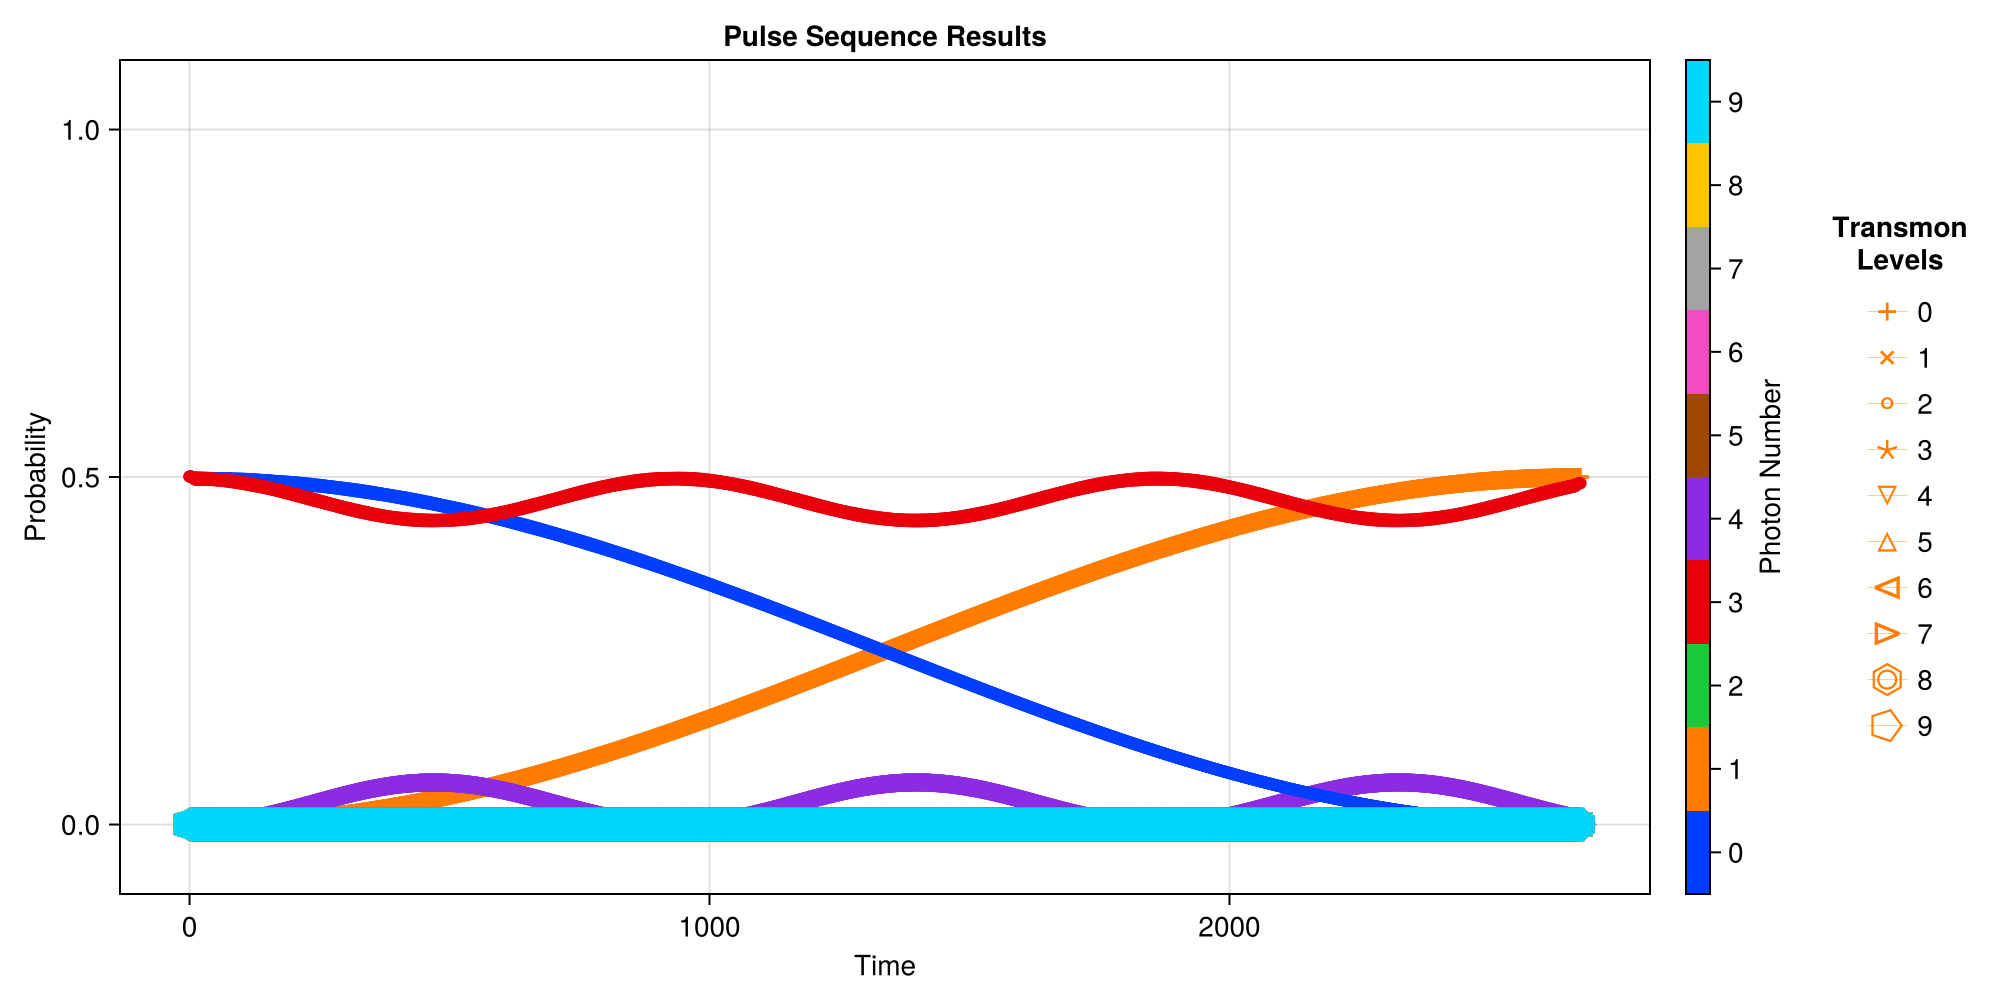

CairoMakie.Screen{IMAGE}


In [16]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, res_f0g1_4pi_f3g4["times"], EVs_Dict)

In [17]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,1)][end])

0.49042394241126036 + 3.3056694818890816e-17im
0.4999473803878987 + 6.834772752583632e-18im


#### Half Sideband $|f1\rangle \to |f1\rangle+|g2\rangle$

In [42]:
Mode5.Stuff["op_drive_params"]["sb_f1g2"]["pulse_time"]

142.88208405212583

In [43]:
starting_args = deepcopy(Mode5.Stuff["op_drive_params"]["sb_f1g2"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]

ψ1 = Mode5.dressed_states[(2,1)]
ψ2 = Mode5.dressed_states[(2,1)] + Mode5.dressed_states[(0,2)]
ψ2 = ψ2/sqrt(2)

proj_op = Mode5.dressed_states[(2,1)]*Mode5.dressed_states[(0,2)]'
op = 2*proj_op# proj_dict[(2,1)]+proj_dict[(0,2)]


t_range = [69.8, 70.2]
t_range = [70.8, 71.2]
t_range = [60, 88]


optimize_res_half_f1g2 = SC.Dynamics.OptimizePulse(Mode5, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 5, samples_per_level = 25, check_op = op)

[2024-11-07 22:36:03] Info: On Level 1
[2024-11-07 22:36:03] Info: On Step 1: t = 60.0
[2024-11-07 22:36:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 22:36:04] Info: Time Evolution Complete
[2024-11-07 22:36:04] Info: Done with Level_1_step_1
[2024-11-07 22:36:04] Info: Accurace: 0.9105434429204421
[2024-11-07 22:36:04] Info: ------------------------------------------------------------------------------
[2024-11-07 22:36:04] Info: On Step 2: t = 61.166666666666664
[2024-11-07 22:36:04] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 22:36:05] Info: Time Evolution Complete
[2024-11-07 22:36:05] Info: Done with Level_1_step_2
[2024-11-07 22:36:05] Info: Accurace: 0.9217735867427919
[2024-11-07 22:36:05] Info: ------------------------------------------------------------------------------
[2024-11-07 22:36

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 77.7408
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>77.7408, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 1.0
  "freq_d"        => -2.3769

In [44]:
#Mode5.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
if GLOBAL_SAVE_CALIBRATE | false
    Mode5.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 77.7408
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>77.7408, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0465381
  "accuracy"      => 1.0
  "freq_d"        => -2.3769

In [45]:
ψ = Mode5.dressed_states[(2,1)]
res_half_f1g2 = SC.Dynamics.RunPulseSequence(Mode5, ψ, ["sb_half_f1g2"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-07T22:39:58.155
It is being saved at: Data/
[2024-11-07 22:39:58] Info: Running operator sb_half_f1g2
[2024-11-07 22:39:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 22:40:00] Info: Time Evolution Complete
[2024-11-07 22:40:00] Info: Saving Steps
[2024-11-07 22:40:01] Info: Done with Step_1
[2024-11-07 22:40:01] Info: Done With Running Sequence
[2024-11-07 22:40:01] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199848, 0.399696, 0.599543, 0.799391, 0.999239, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [46]:
EVs_Dict = SC.Utils.Get_EVs(res_half_f1g2["states"], proj_dict);

[2024-11-07 22:40:01] Info: Making Plot


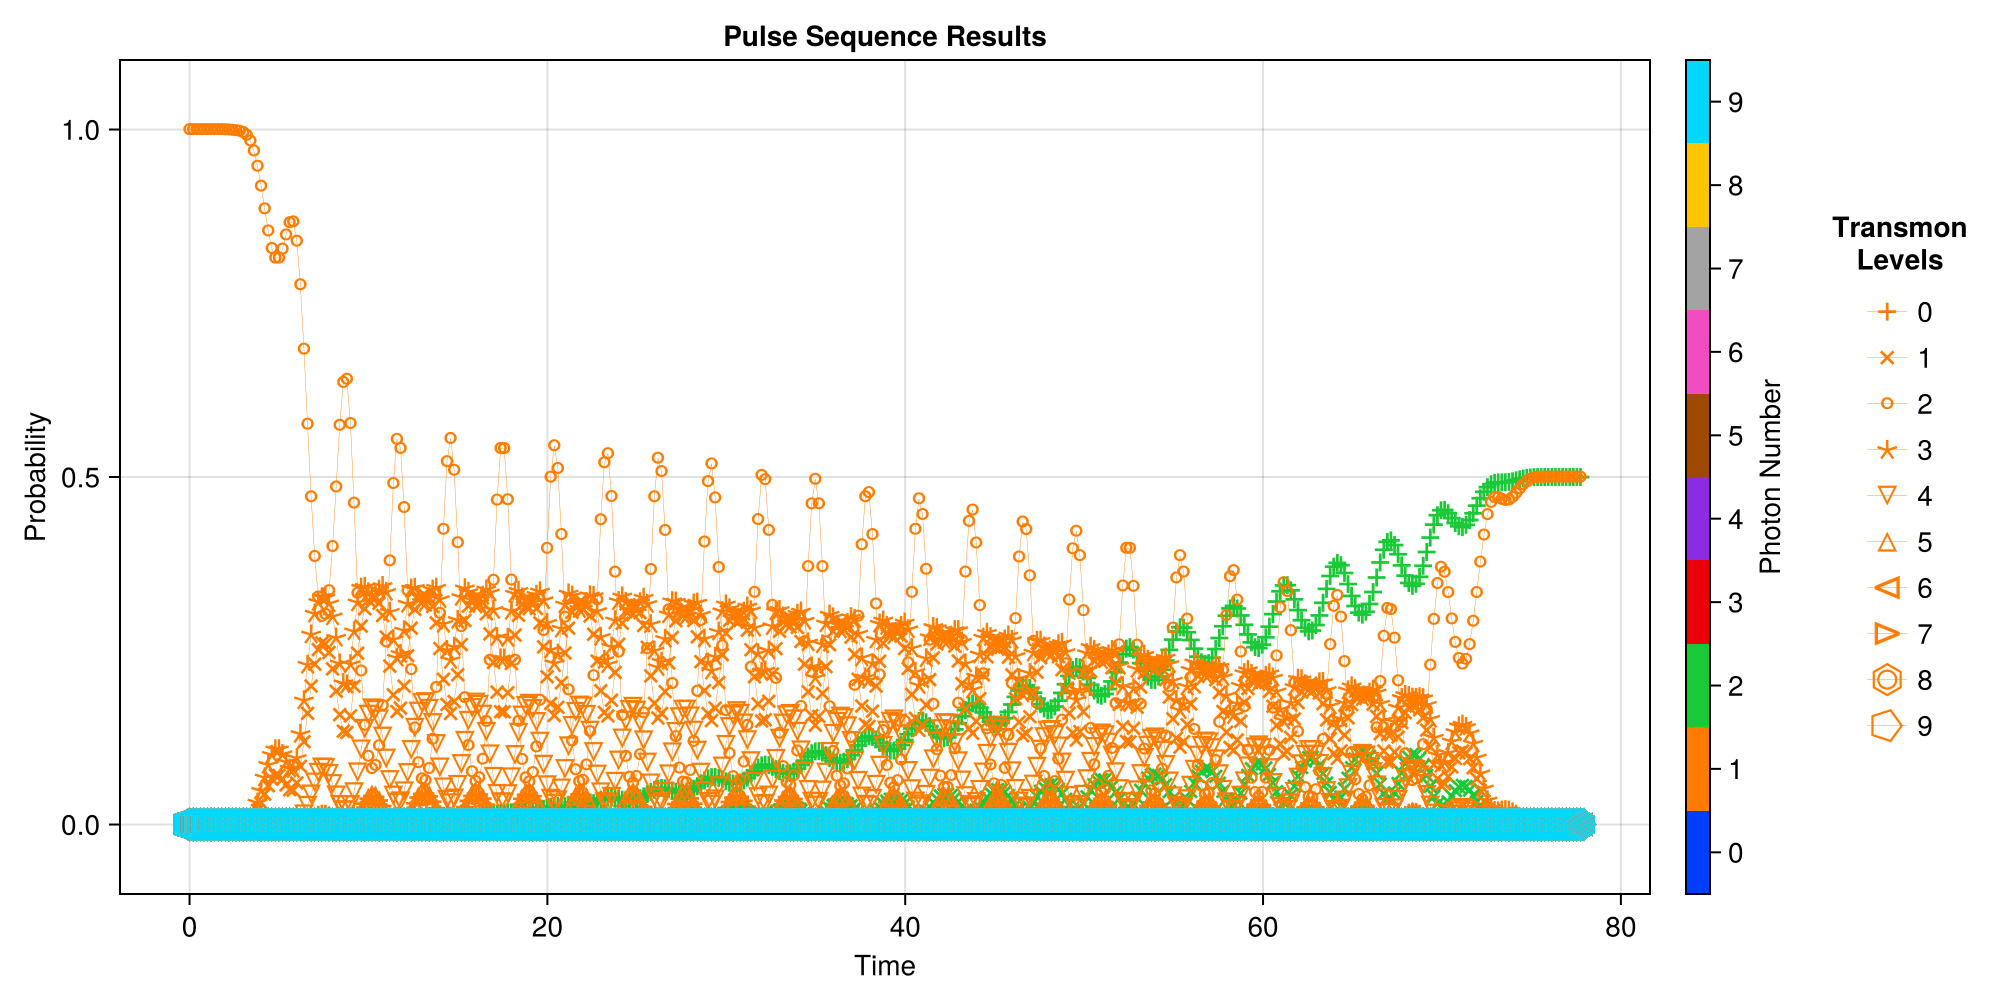

CairoMakie.Screen{IMAGE}


In [47]:
SC.Dynamics.PlotSingleModeEvolution(Mode5, res_half_f1g2["times"], EVs_Dict)

In [ ]:
println(EVs_Dict[(2,1)][end])
println(EVs_Dict[(0,2)][end])

0.49999341288822313 - 6.296685496622432e-17im
0.500006404773965 + 1.4214651829537248e-17im
